In [1]:
import numpy
import datetime
from astropy import wcs
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from matplotlib.image import NonUniformImage
from matplotlib import colormaps

In [2]:
SMALL_SIZE = 28
MEDIUM_SIZE = 28
BIGGER_SIZE = 28

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# constants
deg = numpy.pi/180.
skyArea = 4.*numpy.pi
skyAreaD = skyArea/deg**2

In [4]:
# filter name mapping
fnames = {
    'K': 10,
    'G': 9,
    'F': 1,
    'H': 2,
    'J': 3,
    'Y': 4,
    'Z': 5,
    'R': 6,
    'W': 0,
    'P': 7,
    'D': 8
}

In [5]:
# load bright star catalog
brightstars = numpy.loadtxt('bscat.dat')
N_bsc = numpy.shape(brightstars)[0]
print(N_bsc)
RA_bsc = brightstars[:,0]*deg    # convert to radians
Dec_bsc = brightstars[:,1]*deg

1210


In [6]:
# step old RA/Dec/PA --> new RA/Dec/PA
# all are vectorized (these are numpy arrays) and in radians
def stepfield(RA_, Dec_, PA_, step_up, step_left):
    Nobs = numpy.size(RA_)
    dir_view = numpy.zeros((Nobs,3))
    dir_view[:,0] = numpy.cos(Dec_)*numpy.cos(RA_)
    dir_view[:,1] = numpy.cos(Dec_)*numpy.sin(RA_)
    dir_view[:,2] = numpy.sin(Dec_)
    dir_up = numpy.zeros((Nobs,3))
    dir_up[:,0] = -numpy.sin(Dec_)*numpy.cos(RA_)*numpy.cos(PA_)-numpy.sin(RA_)*numpy.sin(PA_)
    dir_up[:,1] = -numpy.sin(Dec_)*numpy.sin(RA_)*numpy.cos(PA_)+numpy.cos(RA_)*numpy.sin(PA_)
    dir_up[:,2] = numpy.cos(Dec_)*numpy.cos(PA_)
    dir_left = numpy.cross(dir_up,dir_view)
    
    # next step
    dir_new = dir_view + step_up[:,None]*dir_up + step_left[:,None]*dir_left
    dir_new = dir_new / numpy.sqrt(numpy.sum(dir_new**2, axis=1))[:,None]
    RA_new = rephase(numpy.arctan2(dir_new[:,1], dir_new[:,0]))
    Dec_new = numpy.arctan2(dir_new[:,2], numpy.sqrt(dir_new[:,0]**2+dir_new[:,1]**2))
    
    dir_viewX = numpy.zeros((Nobs,3))
    dir_viewX[:,0] = numpy.cos(Dec_new)*numpy.cos(RA_new)
    dir_viewX[:,1] = numpy.cos(Dec_new)*numpy.sin(RA_new)
    dir_viewX[:,2] = numpy.sin(Dec_new)
    dir_nX = numpy.zeros((Nobs,3))
    dir_nX[:,0] = -numpy.sin(Dec_new)*numpy.cos(RA_new)
    dir_nX[:,1] = -numpy.sin(Dec_new)*numpy.sin(RA_new)
    dir_nX[:,2] = numpy.cos(Dec_new)
    dir_eX = numpy.cross(dir_nX,dir_viewX)

    PA_new = rephase(numpy.arctan2(numpy.sum(dir_eX*dir_up,axis=1), numpy.sum(dir_nX*dir_up,axis=1)))
    return RA_new, Dec_new, PA_new

In [7]:
# test for bright stars near a field (thetacut, must be <pi/2)
# RA_bright, Dec_bright as arrays; RA/Dec/PA of observation as scalars
# return i, x_right, x_up
def findBrightStars(RA_bright, Dec_bright, RA_, Dec_, PA_, thetacut):
    
    pos = numpy.vstack((numpy.cos(Dec_bright)*numpy.cos(RA_bright),
                        numpy.cos(Dec_bright)*numpy.sin(RA_bright),
                        numpy.sin(Dec_bright)
        )).T
    pos = pos@ numpy.asarray([[numpy.cos(RA_),-numpy.sin(RA_),0.],
                              [numpy.sin(RA_),numpy.cos(RA_),0.],
                              [0.,0.,1.]])
    # now the x-direction is at the RA of the field
    pos = pos@ numpy.asarray([[-numpy.sin(Dec_),0.,-numpy.cos(Dec_)],
                              [0.,1.,0.],
                              [numpy.cos(Dec_),0.,-numpy.sin(Dec_)]])
    # now x-direction is North, y-direction is East, z-direction is src->obs
    pos = pos@ numpy.asarray([[numpy.cos(PA_),-numpy.sin(PA_),0.],
                              [numpy.sin(PA_),numpy.cos(PA_),0.],
                              [0.,0.,1.]])
    # now the x-direction is up, y-direction is left, z-direction is src->obs

    i = numpy.where(pos[:,2]<-numpy.cos(thetacut))[0]
    return i, -pos[i,1], pos[i,0]


In [8]:
# re-phasing utility: convert angle to 0..2pi
def rephase(z_):
    z__ = numpy.fmod(z_,2*numpy.pi)
    return numpy.where(z__>=0, z__, z__+2*numpy.pi)

# calendar information: mapping ecliptic longitude of the Sun to calendar date
# date is returned in fractions of a year since Jan 1, 2000
#
# https://aa.usno.navy.mil/faq/sun_approx
def SunLong2Date(LtSun):
    f = LtSun - 282.9*deg # true anomaly
    e = 0.01671 # eccentricity
    Ecc = 2*numpy.arctan2(numpy.sqrt((1-e)/(1+e))*numpy.sin(f/2), numpy.cos(f/2))
    M = Ecc-e*numpy.sin(Ecc)
    time_since_ref = LtSun - (f-M)
    return rephase(time_since_ref + 79.54*deg + 0.5/365.25*2*numpy.pi)/(2*numpy.pi)

In [9]:
# read dust file
EBV = numpy.loadtxt('ebv_1e4.dat.gz')/1e4
le = int(numpy.floor(numpy.sqrt(numpy.size(EBV)//2+.001)))
npix = numpy.size(EBV)
EBV = EBV[::-1].reshape((2*le,le)).T
ralist = numpy.linspace(.25/le,1-.25/le,2*le)[::-1]*2*numpy.pi
declist = numpy.arcsin((2*numpy.arange(le)+1)/le-1.)[::-1]
RA,Dec = numpy.meshgrid(ralist,declist)


# get ecliptic latitude & longitude
ctilt,stilt=0.917482062840573,0.397777154152682 # cos & sin of tilt of Earth's axis
xe = numpy.cos(Dec)*numpy.cos(RA)
ye = numpy.cos(Dec)*numpy.sin(RA)*ctilt + numpy.sin(Dec)*stilt
ze = numpy.sin(Dec)*ctilt - numpy.cos(Dec)*numpy.sin(RA)*stilt
beta = numpy.arctan2(ze, numpy.sqrt(xe**2+ye**2))
lamb = numpy.arctan2(-ye,-xe)+numpy.pi
del xe,ye,ze

# and position angle conversion, in the sense of
# PA[Ecliptic] = PA[Equatorial] + dPA
# remember when using this that dPA is in the range of -pi to +pi
dPA = numpy.arctan2(stilt*numpy.cos(Dec)*numpy.cos(RA), ctilt-numpy.sin(Dec)*numpy.sin(beta))

# we'll want a smoothed version, too
EBV_sm = gaussian_filter(EBV,le*5./180.,mode='wrap')

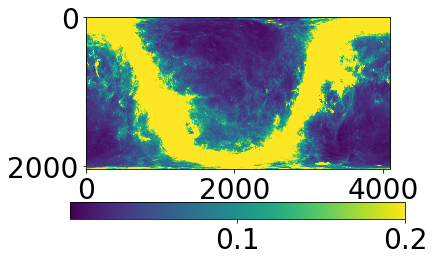

In [10]:
# display dust map
plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(numpy.minimum(EBV,.2), interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.show()

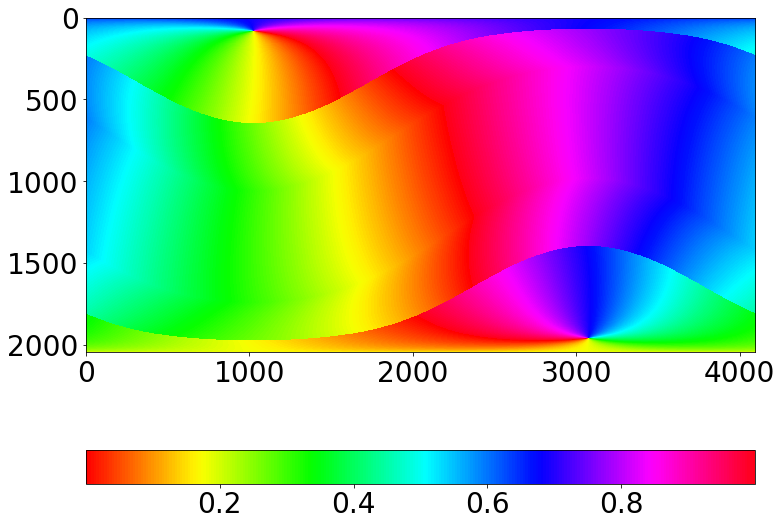

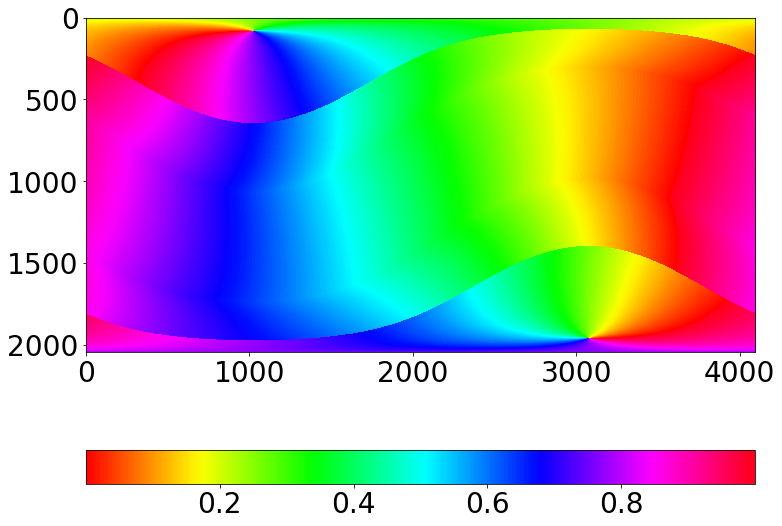

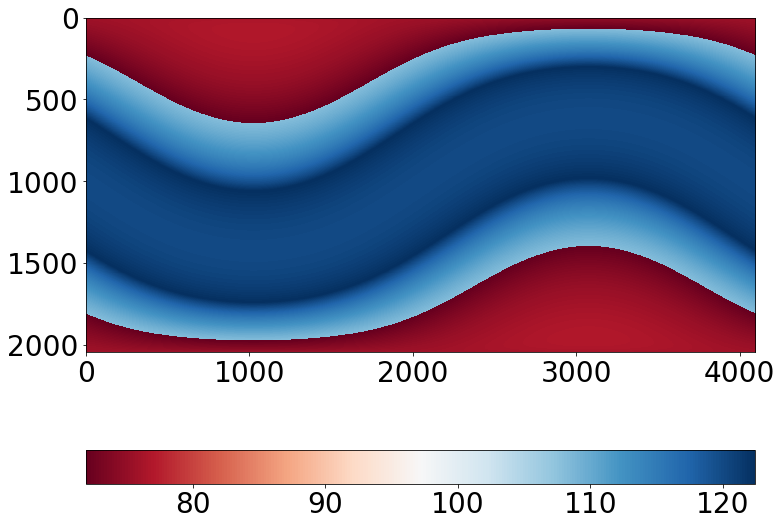

In [11]:
# now figure out when these fields want to be observed.

# first we want the chi-angle: how far South of West (for trailing fields) or South of East (for leading fields)
# the sunshade should point in *Ecliptic* coordinates
#
# note the relations between elongation angle epsilon and longitude relative to the Sun dlam:
# cos epsilon = cos beta * cos dlam
# sin chi = -tan beta * cot epsilon
chi_bdy = 13.*deg
delta_eps_target = 30.*deg # epsilon - pi/2 in the equator
bcrit = 45.*deg
F = numpy.where(numpy.abs(beta)<bcrit, 1., -1.)
chi = -F*numpy.arcsin(numpy.clip(numpy.tan(numpy.clip(beta,-1.5,1.5))*numpy.tan(delta_eps_target), -numpy.sin(chi_bdy), numpy.sin(chi_bdy)))
epsilon = numpy.pi/2 + numpy.clip(numpy.arctan2(-numpy.sin(chi)*numpy.cos(beta)*beta,numpy.sin(beta)*beta),-delta_eps_target,delta_eps_target)
epsilon = numpy.where(numpy.abs(beta)<0.5*deg, numpy.pi/2.+delta_eps_target, epsilon)
dlam = numpy.arccos(numpy.cos(epsilon)/(numpy.cos(beta)+1e-13)) # last part prevents an error exactly at the pole

# WFI position angle when sunshade is facing West
wfi_dpos = 30.*deg

# and the leading and trailing position angles
PA_trail = rephase(wfi_dpos + numpy.where(beta>0, chi_bdy/2.*F, -chi_bdy/2.*F) - dPA)
PA_lead = rephase(wfi_dpos - numpy.where(beta>0, chi_bdy/2.*F, -chi_bdy/2.*F) - dPA + numpy.pi)

# ... and finally the leading and trailing timestamps
LSun_trail = rephase(lamb-dlam)
LSun_lead = rephase(lamb+dlam)
tSun_trail = SunLong2Date(LSun_trail)
tSun_lead = SunLong2Date(LSun_lead)

plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(tSun_lead, interpolation='nearest', cmap=colormaps.get_cmap('hsv'))
plt.colorbar(orientation='horizontal')
plt.show()
plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(tSun_trail, interpolation='nearest', cmap=colormaps.get_cmap('hsv'))
plt.colorbar(orientation='horizontal')
plt.show()


plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(dlam/deg, interpolation='nearest', cmap=colormaps.get_cmap('RdBu'))
plt.colorbar(orientation='horizontal')
plt.show()

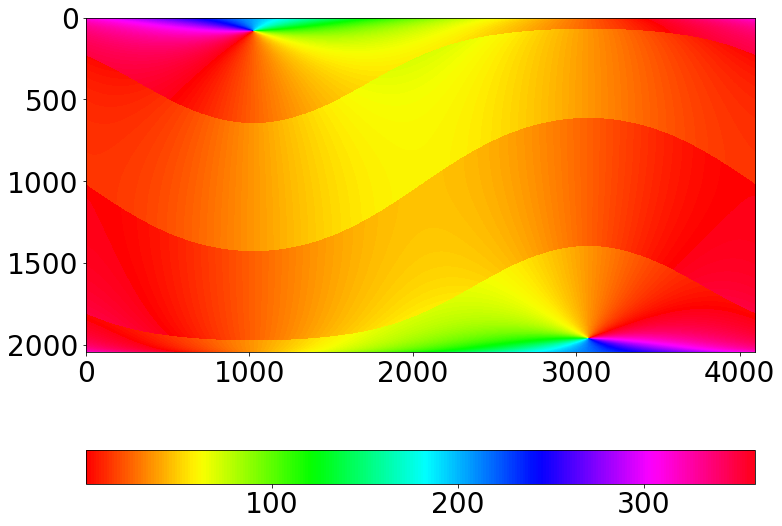

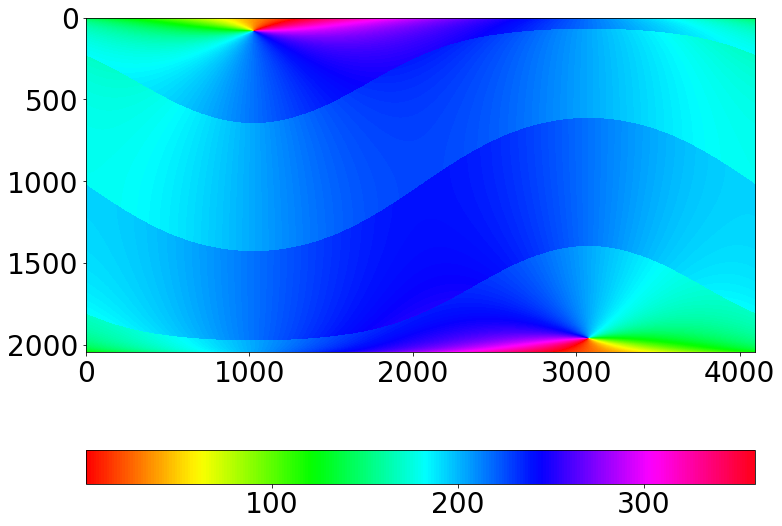

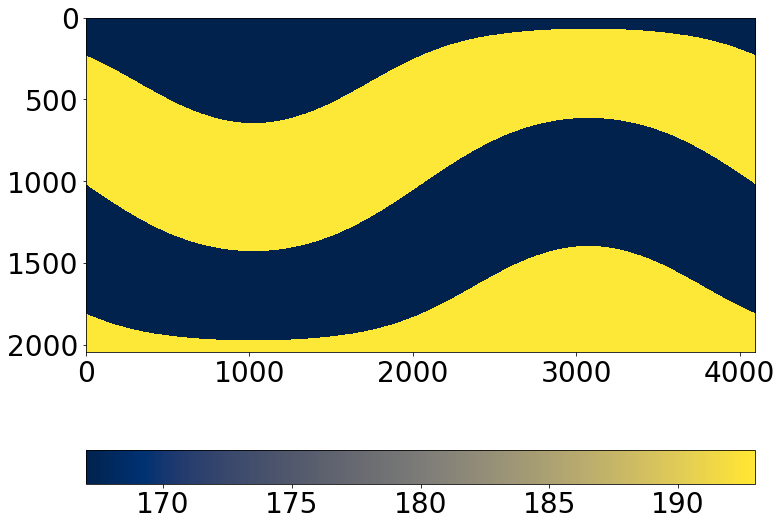

In [12]:
plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(PA_trail/deg, interpolation='nearest', cmap=colormaps.get_cmap('hsv'))
plt.colorbar(orientation='horizontal')
plt.show()
plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(PA_lead/deg, interpolation='nearest', cmap=colormaps.get_cmap('hsv'))
plt.colorbar(orientation='horizontal')
plt.show()

plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(rephase(PA_trail-PA_lead)/deg, interpolation='nearest', cmap=colormaps.get_cmap('cividis'))
plt.colorbar(orientation='horizontal')
plt.show()

In [13]:
# make example footprint
NFP = 2 # number of footprint layers
footprint = numpy.zeros((NFP,le,2*le),dtype=numpy.int8)

#wide
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((Dec<2*deg,Dec>-34*deg,EBV_sm<0.069)), 1, 0)
# encircle COSMOS
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((beta>-25*deg,beta<-6.75*deg,numpy.abs(lamb-153.*deg)<1*deg+.9*(-6*deg-beta))), 1, footprint[0,:,:])
#extension to ELAIS
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((Dec>-46.5*deg, Dec<-30*deg, numpy.cos(RA-9.44*deg)>numpy.cos(8*deg*numpy.tanh(1.4*(Dec+47.5*deg)/(10*deg))))), 1, footprint[0,:,:])
#extension to EDF-S
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((Dec>-51.5*deg, Dec<-30*deg, numpy.cos(RA-61.24*deg)>numpy.cos(10*deg*numpy.tanh(1.4*(Dec+53.5*deg)/(10*deg))))), 1, footprint[0,:,:])
# cut out isolated splotch
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((numpy.abs(RA-205*deg)<8*deg,numpy.abs(Dec+33*deg)<6*deg)), 0, footprint[0,:,:])

# a few more cuts
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((numpy.abs(RA-90*deg)<12*deg,Dec<0*deg)), 0, footprint[0,:,:])

# spectro tier
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((beta<-20*deg,Dec>-28*deg)), 1, 0) * footprint[0,:,:]
# include links to deep fields
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((beta>-25*deg,Dec<-2*deg,numpy.abs(lamb-31.04*deg)<1.*deg+1.1*(-14*deg-beta))), footprint[0,:,:], footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((beta>-25*deg,numpy.abs(lamb-153.*deg)<1*deg+1.2*(-6*deg-beta))), footprint[0,:,:], footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((Dec<-25*deg,numpy.abs(RA-53.12*deg)<1*deg+(32*deg+Dec))), footprint[0,:,:], footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((beta<-20*deg, Dec>-47.*deg, Dec<-25*deg, numpy.cos(RA-9.44*deg)>numpy.cos(8*deg*numpy.tanh(1.4*(Dec+47.5*deg)/(10*deg))))), 1, footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((beta>-35*deg, beta<-20*deg, numpy.abs(lamb-20*deg)<20*deg)), footprint[0,:,:],footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((Dec>-53.5*deg, Dec<-26*deg, numpy.cos(RA-61.24*deg)>numpy.cos(10*deg*numpy.tanh(1.4*(Dec+55.5*deg)/(10*deg))))), 1, footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((RA>12*deg,RA<60*deg,Dec<-20*deg,Dec>-39.1*deg)), 1, footprint[1,:,:])
# cut out corner
footprint[1,:,:] = numpy.where(numpy.abs(lamb-330*deg)<12*deg,0,footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.abs(lamb-185*deg)<16*deg,0,footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.logical_and.reduce((numpy.abs(RA-150*deg)<40*deg,Dec<-16*deg)),0,footprint[1,:,:])
footprint[1,:,:] = numpy.where(numpy.abs(RA-116.5*deg)<25*deg,0,footprint[1,:,:])
footprint[1,:,:] = numpy.where(RA>340*deg,0,footprint[1,:,:])
footprint[1,:,:] = numpy.where(RA<0.5*deg,0,footprint[1,:,:])
# include Sculptor in medium
muSculptor = numpy.cos(Dec)*numpy.cos(-25.3*deg)*numpy.cos(RA-11.9*deg) + numpy.sin(Dec)*numpy.sin(-25.3*deg)
footprint[1,:,:] = numpy.where(numpy.logical_and(muSculptor>1.-2/41253.*500.,beta<-20*deg),1,footprint[1,:,:])
del muSculptor


# cut out the 'worst' area from wide
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((footprint[1,:,:]==0,EBV_sm>0.056)), 0, footprint[0,:,:])
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((footprint[1,:,:]==0,Dec<-31.6*deg)), 0, footprint[0,:,:])
footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((footprint[1,:,:]==0,numpy.abs(RA-223.*deg)<20*deg)), 0, footprint[0,:,:])


# a square for test
#footprint[0,:,:] = numpy.where(numpy.logical_and.reduce((Dec>30*deg,Dec<60*deg,RA>170*deg,RA<210*deg)),1,footprint[0,:,:])

# now remove repetition of footprint
footprint[0,:,:] = footprint[0,:,:]*(1-footprint[1,:,:])

fpN = footprint*numpy.where(0.8899741598379232*numpy.cos(Dec)*numpy.cos(RA-192.85*deg) + 0.45601095910162387*numpy.sin(Dec)>0,1,0)[None,:,:]
Area = numpy.mean(footprint,axis=(1,2))*skyAreaD
print('total areas', Area)
print(numpy.cumsum(Area[::-1])[::-1])
AreaN = numpy.mean(fpN,axis=(1,2))*skyAreaD
print('Northern Cap', AreaN)
print(numpy.cumsum(AreaN[::-1])[::-1])
for dcut in [-40,-30,-20]:
    AreaDe = numpy.mean(footprint*numpy.where(Dec>dcut*deg,1,0)[None,:,:],axis=(1,2))*skyAreaD
    print(f'> {dcut} deg', AreaDe)
    print(numpy.cumsum(AreaDe[::-1])[::-1])

total areas [2702.40423342 2414.57405123]
[5116.97828465 2414.57405123]
Northern Cap [1108.19218227  331.52426835]
[1439.71645062  331.52426835]
> -40 deg [2702.40423342 2230.53760933]
[4932.94184275 2230.53760933]
> -30 deg [2643.52909561 1683.35093756]
[4326.88003316 1683.35093756]
> -20 deg [2250.29707339  979.16061979]
[3229.45769318  979.16061979]


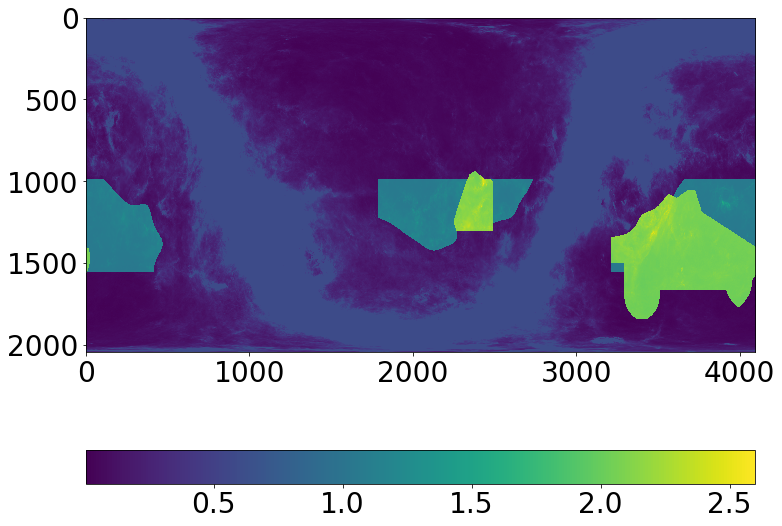

In [14]:
# display dust map
plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(footprint[0,:,:]+2*footprint[1,:,:]+numpy.minimum(EBV,.2)*3, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.show()

[array([  1155,  96915, 230563, 147281,  52834,  14220,   3619,   1344,
          625,    406,    200,    135,     74,     38,     45,     21]), array([ 57839, 229410,  84027,  57910,  30646,  17507,   7630,   3182,
         1297,    696,    330,    223,    142,     83,     39,     22])]


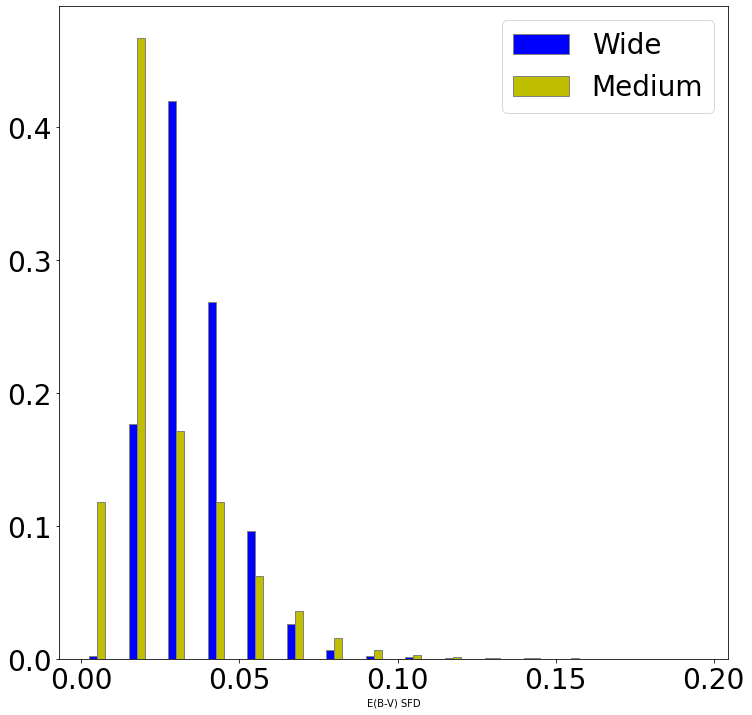

50.0 0.0302
75.0 0.0415
90.0 0.0532
95.0 0.0624
99.0 0.0851


In [15]:
hist_EBV = []
for i in range(NFP):
    h, be_EBV = numpy.histogram(EBV[footprint[i,:,:]==1],bins=16,range=(0,0.2))
    hist_EBV += [h]

print(hist_EBV)
c = ['b', 'y']
lb = ['Wide', 'Medium']
barWidth = 0.0025
o = (be_EBV[1]-be_EBV[0])/2.-barWidth
plt.xlabel('E(B-V) SFD')
for i in range(NFP):
    plt.bar(be_EBV[:-1]+o+i*barWidth, hist_EBV[i]/numpy.sum(hist_EBV[i]), color =c[i], width = barWidth, 
        edgecolor ='grey', label =lb[i]) 
plt.legend()
plt.show()

# print statistics
for p in [50.,75.,90.,95.,99.]:
    print(p, numpy.percentile(EBV[numpy.sum(footprint,axis=0)>=1],p))

[array([145128, 119281, 113498, 108419,  48299,  10585,      0,      0,
            0,     30,   4282,      0,      0,      0,      0,      0,
            0,      0]), array([    0,  4473, 16721, 31098, 73476, 64519, 61965, 63486, 64017,
       44231, 24696, 16584, 14376, 10066,  1285,     0,     0,     0])]


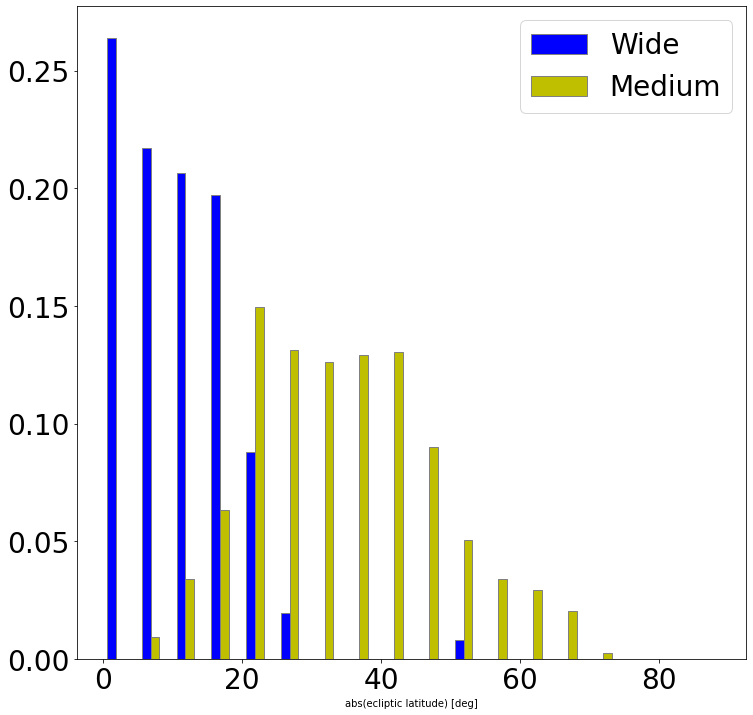

10.0 19.559369339905658
25.0 24.78324271793691
50.0 34.45676595438778
75.0 43.98118374941459
90.0 53.29254149473046


In [16]:
hist_beta = []
for i in range(NFP):
    h, be_beta = numpy.histogram(numpy.abs(beta[footprint[i,:,:]==1])/deg,bins=18,range=(0,90))
    hist_beta += [h]

print(hist_beta)
barWidth = 1.25
o = (be_beta[1]-be_beta[0])/2.-barWidth
plt.xlabel('abs(ecliptic latitude) [deg]')
for i in range(NFP):
    plt.bar(be_beta[:-1]+o+i*barWidth, hist_beta[i]/numpy.sum(hist_beta[i]), color =c[i], width = barWidth, 
        edgecolor ='grey', label =lb[i]) 
plt.legend()
plt.show()

# print statistics
for p in [10., 25., 50., 75., 90.]:
    print(p, numpy.percentile(numpy.abs(beta[footprint[1,:,:]>=1]),p)/deg)

[array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0, 11972, 23186, 22682, 34094, 46628, 55707, 69885,
       79405, 75227, 81786, 48950,     0,     0,     0,     0,     0]), array([    0,     0,     0,     0,   131,  4125,  6797, 11093, 15277,
       31753, 37930, 41585, 44810, 49148, 49236, 42643, 43573, 39191,
       29944, 23053, 12304,  7596,   804,     0,     0,     0,     0])]


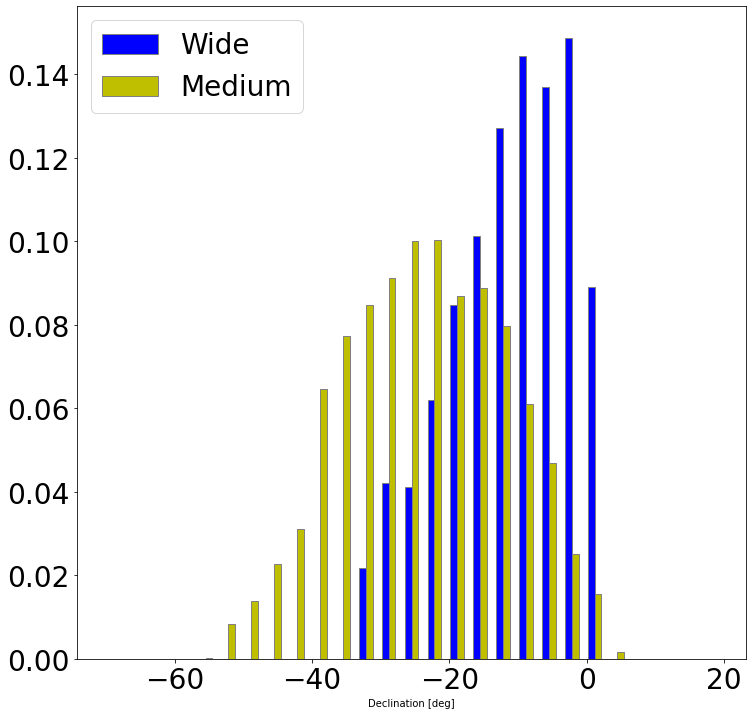

In [17]:
hist_Dec = []
for i in range(NFP):
    h, be_Dec = numpy.histogram(Dec[footprint[i,:,:]==1]/deg,bins=27,range=(-70,20))
    hist_Dec += [h]

print(hist_Dec)
barWidth = 1.
o = (be_Dec[1]-be_Dec[0])/2.-barWidth
plt.xlabel('Declination [deg]')
for i in range(NFP):
    plt.bar(be_Dec[:-1]+o+i*barWidth, hist_Dec[i]/numpy.sum(hist_Dec[i]), color =c[i], width = barWidth, 
        edgecolor ='grey', label =lb[i]) 
plt.legend()
plt.show()

[array([21448, 51007, 56039, 42339,  6804,     0,   967,  4043, 11676,
       23810, 10137,  4395, 30726, 49953, 48839, 51745, 52383, 52493,
       55875, 47501, 39333, 32228, 26284,  8917,  2529,     0,     0,
        8925, 44823, 54142, 58536, 50443, 45296, 55761, 39558, 10089]), array([57422, 32007, 28121, 34059, 30908, 25107, 14639,  6802,    23,
           0, 23019, 35687,  8708,   320,     0,   696,  4849, 19152,
       50016, 67686, 66631, 58177, 47980, 49748, 39948, 14922,  3454,
           0,     0,     0,  1854, 30320, 41409, 42576, 59438, 86308])]


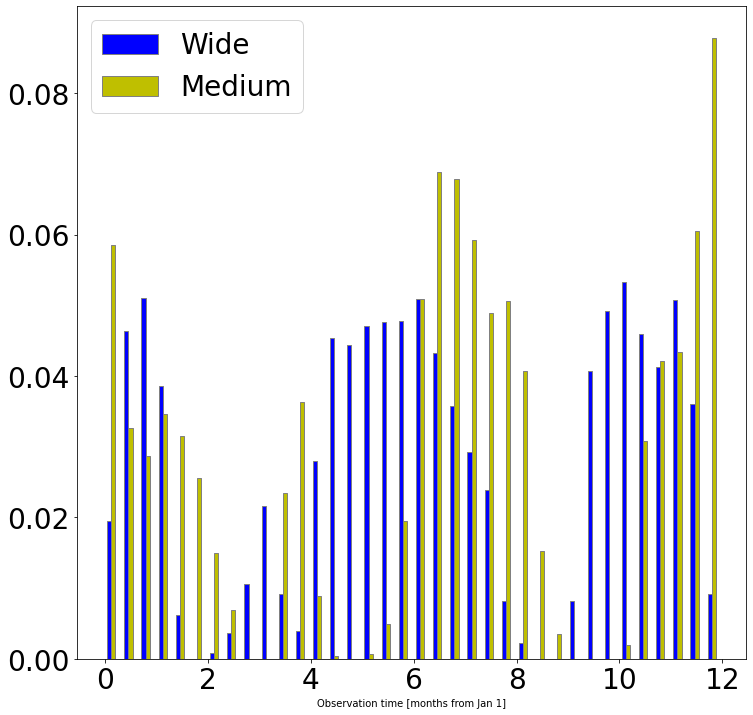

In [18]:
hist_date = []
for i in range(NFP):
    h1, be_date = numpy.histogram(12*tSun_lead[footprint[i,:,:]==1],bins=36,range=(0,12))
    h2, be_date = numpy.histogram(12*tSun_trail[footprint[i,:,:]==1],bins=36,range=(0,12))
    hist_date += [h1+h2]

print(hist_date)
barWidth = 0.08
o = (be_date[1]-be_date[0])/2.-barWidth
plt.xlabel('Observation time [months from Jan 1]')
for i in range(NFP):
    plt.bar(be_date[:-1]+o+i*barWidth, hist_date[i]/numpy.sum(hist_date[i]), color =c[i], width = barWidth, 
        edgecolor ='grey', label =lb[i]) 
plt.legend()
plt.show()

In [19]:
# print to FITS image
w = wcs.WCS(naxis=2)
w.wcs.crpix = [le+.5, (le+1)/2.]
w.wcs.cdelt = [-180./le, 180./le*2./numpy.pi]
w.wcs.crval = [180., 0.]
w.wcs.ctype = ["RA---CEA", "DEC--CEA"]
outimage = footprint[0,:,:]+2*footprint[1,:,:]+numpy.minimum(EBV,.2)*3
fits.PrimaryHDU(outimage[::-1,:], header=w.to_header()).writeto('footprint.fits', overwrite=True)

[[2.92531192 2.92528642 2.92526128 ... 2.92539048 2.92536395 2.92533776]
 [2.8173023  2.81723788 2.81717404 ... 2.81749906 2.81743289 2.8173673 ]
 [2.74394548 2.74384492 2.74374509 ... 2.7442515  2.74414877 2.74404676]
 ...
 [9.53480448 9.53474451 9.53468381 ... 9.53498007 9.53492226 9.53486373]
 [9.4607041  9.46067105 9.46063741 ... 9.4607998  9.46076848 9.46073658]
 [9.35200113 9.35199372 9.35198595 ... 9.35202131 9.35201493 9.35200821]]


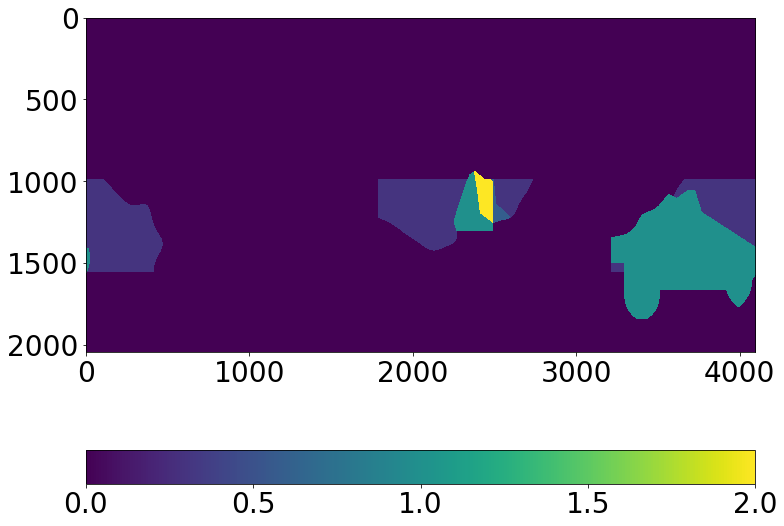

In [20]:
# display map of observations between month_min and month_max
plt.rcParams['figure.figsize'] = [12,12]
print(12*tSun_trail)
month_min=3.333
month_max=3.667
c1 = numpy.where(numpy.logical_and.reduce((12*tSun_trail>=month_min,12*tSun_trail<month_max)),1,0)
c2 = numpy.where(numpy.logical_and.reduce((12*tSun_lead>=month_min,12*tSun_lead<month_max)),1,0)
plt.imshow((footprint[1,:,:]+.3*footprint[0,:,:])*(1+c1+c2), interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.show()

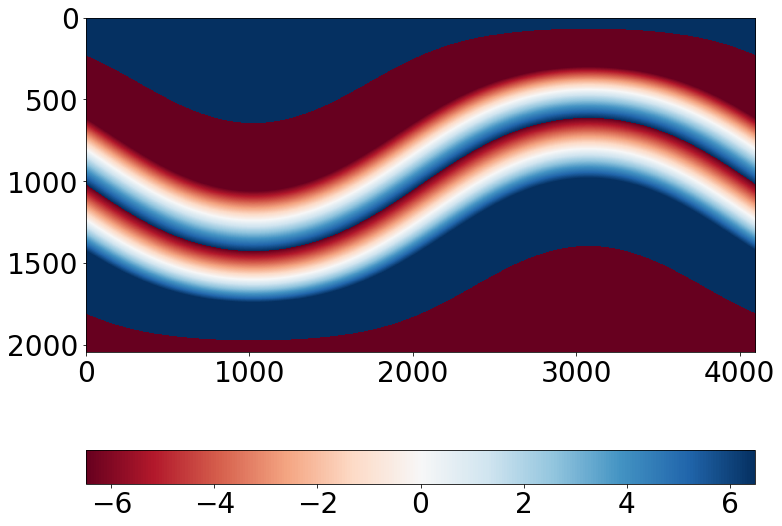

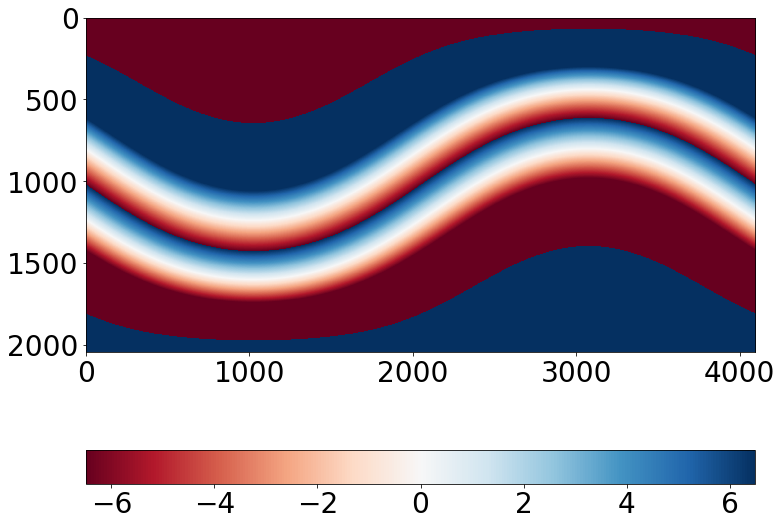

In [21]:
# check roll angles
# North & EAst directions
XN, YN, ZN = -numpy.sin(Dec)*numpy.cos(RA), -numpy.sin(Dec)*numpy.sin(RA), numpy.cos(Dec)
XE, YE = -numpy.sin(RA), numpy.cos(RA) # ZE=0

XSun, YSun, ZSun = numpy.cos(LSun_trail), ctilt*numpy.sin(LSun_trail), stilt*numpy.sin(LSun_trail)
roll_trail = rephase(PA_trail - wfi_dpos - 90.*deg - numpy.arctan2(XE*XSun+YE*YSun, XN*XSun+YN*YSun+ZN*ZSun) + numpy.pi)-numpy.pi

XSun, YSun, ZSun = numpy.cos(LSun_lead), ctilt*numpy.sin(LSun_lead), stilt*numpy.sin(LSun_lead)
roll_lead = rephase(PA_lead - wfi_dpos - 90.*deg - numpy.arctan2(XE*XSun+YE*YSun, XN*XSun+YN*YSun+ZN*ZSun) + numpy.pi)-numpy.pi


plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(roll_trail/deg, interpolation='nearest', cmap=colormaps.get_cmap('RdBu'))
plt.colorbar(orientation='horizontal')
plt.show()
plt.rcParams['figure.figsize'] = [12,12]
plt.imshow(roll_lead/deg, interpolation='nearest', cmap=colormaps.get_cmap('RdBu'))
plt.colorbar(orientation='horizontal')
plt.show()

In [22]:
# information on the passes
passes = {
    'Ngrp': 10,
    'lead': numpy.asarray([0,1,0,1,0,1,0,0,1,1]).astype(numpy.int8),
    'angles': numpy.asarray([2,2,0,0,-2,-2,-3,3,-3,3])*deg,
    'filters': numpy.asarray([2,2,3,3,4,4,9,9,9,9]).astype(numpy.int8),
    'ndither': numpy.asarray([3,3,3,3,3,3,2,2,2,2]).astype(numpy.int8),
    'medonly': numpy.asarray([0,0,1,1,1,1,1,1,1,1]).astype(bool)
}

# long FoV step
longStep = 0.794*deg # original was 0.794 deg

In [23]:
# get pseudo-rapidity
Q = numpy.pi/2.-1e-11
eta = numpy.log(numpy.tan(numpy.pi/4.+numpy.clip(beta,-Q,Q)/2.))
Nband_lon = 30
Nband_tot = 4*Nband_lon

cc = numpy.asarray([1,-1,-1,1])

In [24]:
# generate an array of pointings from
# latitude, longitude, position angle, and vertical & horizontal steps
# convert ecliptic to equatorial coordinates if ecl2equ is True
# (otherwise no coordinate conversion takes place, assumed to initially be in Dec/RA)
#
# PA can be a number or array
#
def grid_multistep(B1, L1, P1, dv, dh, ecl2equ=True, ditherseed=0, vscramble=0):
    nb = numpy.size(B1)
    ns = numpy.size(dv)
    
    # which direction is "up" (WFI +Y)?
    up_ = numpy.zeros((nb,3))
    up_[:,0] = -numpy.sin(B1)*numpy.cos(L1)*numpy.cos(P1)-numpy.sin(L1)*numpy.sin(P1)
    up_[:,1] = -numpy.sin(B1)*numpy.sin(L1)*numpy.cos(P1)+numpy.cos(L1)*numpy.sin(P1)
    up_[:,2] = numpy.cos(B1)*numpy.cos(P1)
    
    # direction of starting positions
    start_ = numpy.zeros((nb,3))
    start_[:,0] = numpy.cos(B1)*numpy.cos(L1)
    start_[:,1] = numpy.cos(B1)*numpy.sin(L1)
    start_[:,2] = numpy.sin(B1)
    
    if ecl2equ:
        up_    = up_    @numpy.asarray([[1.,0.,0.],[0.,ctilt,stilt],[0.,-stilt,ctilt]])
        start_ = start_ @numpy.asarray([[1.,0.,0.],[0.,ctilt,stilt],[0.,-stilt,ctilt]])
        
    if vscramble>0:
        start_ = start_ + up_*0.419*deg*(numpy.modf(numpy.pi*vscramble*numpy.arange(1,nb+1)**2)[0]-.5)[:,None]

    # ... and the 'transverse' direction (to the left, looking at the sky)
    trans_ = numpy.cross(up_,start_)
    
    # coordinate matrix
    coords = numpy.tensordot(numpy.cos(dv)*numpy.cos(dh),start_,axes=0)\
             + numpy.tensordot(numpy.sin(dv)*numpy.cos(dh),up_,axes=0)\
             + numpy.tensordot(numpy.sin(dh),trans_,axes=0)
    coords = numpy.transpose(coords, axes=(1,0,2))
    for j in range(0,nb,2):
        coords[j,:,:] = coords[j,::-1,:]
    coords = coords.reshape((nb*ns,3))

    # get the latitude and longitude in this system
    lon = rephase(numpy.arctan2(coords[:,1],coords[:,0]))
    lat = numpy.arctan2(coords[:,2],numpy.sqrt(coords[:,0]**2+coords[:,1]**2))

    # and the position angle
    modup = numpy.zeros((nb,ns,3))
    modup = (modup + up_[:,None,:]).reshape((nb*ns,3))
    northvec = numpy.zeros_like(coords)
    northvec[:,0] = -numpy.sin(lat)*numpy.cos(lon)
    northvec[:,1] = -numpy.sin(lat)*numpy.sin(lon)
    northvec[:,2] = numpy.cos(lat)
    eastvec = numpy.cross(northvec,coords)
    pa = rephase(numpy.arctan2(numpy.sum(eastvec*modup,axis=1), numpy.sum(northvec*modup,axis=1)))
    
    return lat,lon,pa

In [25]:
# column indicators
col = {
    'dec': 0,
    'ra': 1,
    'pa': 2,
    'grp': 3,
    'filter': 4,
    'EBV': 5,
    'LtSun_opt': 6,
    't_exp': 7,
    'layer': 8
}

In [26]:
# now tile the medium and wide tiers
n_start = 0 # <== keep at 0 except for testing
n_alloc = passes['Ngrp'] # <== change to passes['Ngrp']
pointings = numpy.zeros((0,len(col.keys())))
for ipass in range(n_start,n_alloc):
    print(ipass)
        
    # pass information
    if passes['ndither'][ipass]==3:
        vstep = 0.140*deg
        sstep = 0.0305*deg
        dstep = 0.018*deg
    else:
        vstep = 0.209*deg
        sstep = 0.0000*deg
        dstep = 0.018*deg
    Nt = int(numpy.ceil(15*deg/vstep))
    dv = vstep * numpy.linspace(-(Nt-1)/2.,(Nt-1)/2.,Nt) + sstep * (numpy.arange(Nt,dtype=numpy.int16)%passes['ndither'][ipass])
    dh = dstep * (numpy.arange(Nt,dtype=numpy.int16)%passes['ndither'][ipass])

    # now we can tile each band
    for iband in range(Nband_tot):
        
        # get band structure
        C = -1.
        if passes['lead'][ipass]==1: C = -C
        if passes['lead'][ipass]==1: C = -C
        a1 = wfi_dpos+passes['angles'][ipass] + C*chi_bdy/2.
        a2 = wfi_dpos+passes['angles'][ipass] - C*chi_bdy/2.
        f1 = numpy.tan(numpy.abs(a1))
        f2 = numpy.tan(numpy.abs(a2))
        s1 = numpy.sin(numpy.abs(a1))
        s2 = numpy.sin(numpy.abs(a2))
        etabar = numpy.abs(eta)
        dlon = -numpy.where(numpy.abs(beta)<bcrit, etabar/f2, (1/f2-1/f1)*numpy.log(numpy.tan(45.*deg+bcrit/2.))+etabar/f1)
        dlon *= numpy.where(beta>0,1,-1)
        lref = rephase(lamb - dlon)
        del etabar, dlon
        # and assign band indices
        band = 4*numpy.clip(numpy.floor(lref/(2*numpy.pi)*Nband_lon).astype(numpy.int16),0,Nband_lon-1)
        band += numpy.where(beta>0,2,0)
        band += numpy.where(numpy.abs(beta)<bcrit,1,0)
    
        # now build 'starting' set in each tier
        x = []
        SX = 1.0 if passes['filters'][ipass]!=9 else 1.01
        beta__ = numpy.pi/2. - longStep*SX
        while(beta__>=-numpy.pi/2.+longStep*SX):
            x.append(beta__)
            if numpy.abs(beta__)<bcrit:
                beta__ -= longStep*SX*s1
            else:
                beta__ -= longStep*SX*s2
        beta_start = numpy.asarray(x)
        del x
        etabar_start = numpy.log(numpy.tan(numpy.pi/4.+numpy.clip(numpy.abs(beta_start),-Q,Q)/2.))
        
        # get starting ecliptic longitude
        lamb_start = numpy.where(numpy.abs(beta_start)<bcrit, etabar_start/f1, (1/f1-1/f2)*numpy.log(numpy.tan(45.*deg+bcrit/2.))+etabar_start/f2)
        lamb_start *= -numpy.where(beta_start>0,1,-1)
        lamb_start = rephase(lamb_start)


        beta_init = numpy.copy(beta_start)
        lamb_init = rephase(lamb_start + (iband//4) * 2*numpy.pi/Nband_lon)
        ct = 1
        if passes['lead'][ipass]==1:
            ct=-ct
        eclPA = wfi_dpos + ct*chi_bdy/2. * cc[iband%4]
        if passes['lead'][ipass]==1:
            eclPA = eclPA + numpy.pi
        eclPA = rephase(eclPA)

        # get the grid positions
        lat,lon,pa = grid_multistep(beta_init, lamb_init, eclPA, dv, dh, ecl2equ=True)
        # and test whether they're in this band
        xe = numpy.cos(lat)*numpy.cos(lon)
        ye = numpy.cos(lat)*numpy.sin(lon)*ctilt + numpy.sin(lat)*stilt
        ze = numpy.sin(lat)*ctilt - numpy.cos(lat)*numpy.sin(lon)*stilt
        betabar = numpy.arctan2(ze, numpy.sqrt(xe**2+ye**2))
        lambbar = numpy.arctan2(-ye,-xe)+numpy.pi
        del xe,ye,ze
        etabar = numpy.log(numpy.tan(numpy.pi/4.+numpy.clip(numpy.abs(betabar),-Q,Q)/2.))
        dlon = -numpy.where(numpy.abs(betabar)<bcrit, etabar/f1, (1/f1-1/f2)*numpy.log(numpy.tan(45.*deg+bcrit/2.))+etabar/f2)
        dlon *= numpy.where(betabar>0,1,-1)
        lrefX = rephase(lambbar - dlon)
        del etabar, dlon

        # (possibly) dither the band edges
        lo = 0.125*deg
        bandTile = 4*numpy.clip(numpy.floor((lrefX+lo)/(2*numpy.pi)*Nband_lon).astype(numpy.int16),0,Nband_lon-1)
        bandTile += numpy.where(betabar>0,2,0)
        bandTile += numpy.where(numpy.abs(betabar)<bcrit,1,0)
        bandTile2 = 4*numpy.clip(numpy.floor((lrefX-lo)/(2*numpy.pi)*Nband_lon).astype(numpy.int16),0,Nband_lon-1)
        bandTile2 += numpy.where(betabar>0,2,0)
        bandTile2 += numpy.where(numpy.abs(betabar)<bcrit,1,0)
        bandTile3 = 4*numpy.clip(numpy.floor((lrefX)/(2*numpy.pi)*Nband_lon).astype(numpy.int16),0,Nband_lon-1)
        bandTile3 += numpy.where(betabar>0,2,0)
        bandTile3 += numpy.where(numpy.abs(betabar+0.375*deg)<bcrit,1,0)
        
        # can print diagnostic -- -1 means don't print
        if iband==-1:
            c1 = 48000; c2 = 48100; st = 6
            print(numpy.size(dv), numpy.size(beta_init), numpy.size(dv)*numpy.size(beta_init), lamb_start[c1//numpy.size(dv)]/deg)
            print(beta_init[c1//numpy.size(dv)]/deg, lamb_init[c1//numpy.size(dv)]/deg, eclPA/deg)
            print(lat[c1:c2:st]/deg, lon[c1:c2:st]/deg, pa[c1:c2:st]/deg)
        
        # select out the pointings that we use
        # lookup points
        ix = numpy.floor(2*le-le*lon/numpy.pi).astype(numpy.int16)
        iy = numpy.floor(le*(1-numpy.sin(lat))/2.).astype(numpy.int16)
        
        u = numpy.logical_and(numpy.logical_or.reduce((bandTile==iband,bandTile2==iband,bandTile3==iband)), footprint[1,iy,ix]+footprint[0,iy,ix]*(1-passes['medonly'][ipass])>0)

        lat = lat[u]
        lon = lon[u]
        pa = pa[u]
        grp = ipass*Nband_tot + bandTile[u]
        iy = iy[u]
        ix = ix[u]
                
        if numpy.count_nonzero(u)>0:
            LtSun = LSun_lead if passes['lead'][ipass]>0 else LSun_trail
            newpointings = numpy.vstack((lat, lon, pa, grp, grp, EBV[iy,ix], LtSun[iy,ix], grp, grp)).T
            newpointings[:,col['filter']] = passes['filters'][ipass]
            newpointings[:,col['layer']] = numpy.where(footprint[1,iy,ix]>0, 1, 0)
            
            # exposure times
            if passes['filters'][ipass]==9:
                newpointings[:,col['t_exp']] = 189.41
            else:
                newpointings[:,col['t_exp']] = 106.40

            pointings = numpy.vstack((pointings, newpointings)) # angles in degrees
        
    #plt.rcParams['figure.figsize'] = [12,12]
    #plt.imshow(band%8, interpolation='nearest', cmap=colormaps.get_cmap('viridis'))
    #plt.colorbar(orientation='horizontal')
    #plt.show()           


0
1
2
3
4
5
6
7
8
9


In [27]:
# add deep fields
ted = 294.88
deepfields = [
    {'Name': 'COSMOS', 'RAc': 150.10*deg, 'DECc': 2.19*deg, 'r': 1.88*deg, 'filt': 'ZYJHFKWG',
     'passes': [5,5,5,5,5,5,6,36], 't_exp': [ted]*7+[189.41]},
    {'Name': 'COSMOS-UltraDeep', 'RAc': 150.14*deg, 'DECc': 2.19*deg, 'r': 1.26*deg, 'filt': 'YJH',
     'passes': [10,10,10], 't_exp': [ted]*3},
    {'Name': 'XMM-LSS', 'RAc': 35.71*deg, 'DECc': -4.75*deg, 'r': 1.88*deg, 'filt': 'ZYJHFKWG',
     'passes': [5,5,5,5,5,5,6,36], 't_exp': [ted]*7+[189.41]}
]
#    {'Name': 'EDF-Sa', 'RAc': 58.80*deg, 'DECc': -49.20*deg, 'r': 1.78*deg, 'filt': 'ZYJHFKG',
#     'passes': [5,5,5,5,5,5,36], 't_exp': [ted]*6+[188.48]},
#    {'Name': 'EDF-Sb', 'RAc': 63.80*deg, 'DECc': -47.60*deg, 'r': 1.78*deg, 'filt': 'ZYJHFKG',
#     'passes': [5,5,5,5,5,5,36], 't_exp': [ted]*6+[188.48]},

grp = Nband_tot*passes['Ngrp']
for d in deepfields:
    Dec_ = d['DECc']
    RA_ = d['RAc']
    beta_ = numpy.arcsin(ctilt*numpy.sin(Dec_) - stilt*numpy.cos(Dec_)*numpy.sin(RA_))
    lamb_ = numpy.arctan2(-(numpy.cos(Dec_)*numpy.sin(RA_)*ctilt + numpy.sin(Dec_)*stilt),
                -numpy.cos(Dec_)*numpy.cos(RA_))+numpy.pi
    dPA_ = numpy.arctan2(stilt*numpy.cos(Dec_)*numpy.cos(RA_), ctilt-numpy.sin(Dec_)*numpy.sin(beta_))
    r = 11.5*deg
    bowtie_halfwidth2 = r + numpy.arcsin(numpy.clip(numpy.tan(33.0*deg)*numpy.tan(numpy.clip(numpy.abs(beta_)-d['r'],0,80*deg)),0,numpy.cos(r)))
    bowtie_halfwidth1 = bowtie_halfwidth2
    if numpy.abs(beta_)<30*deg: bowtie_halfwidth1 = r + numpy.arcsin(numpy.clip(numpy.tan(15.0*deg)*numpy.tan(numpy.clip(numpy.abs(beta_)-d['r'],0,80*deg)),0,numpy.cos(r)))
    bowtie_halfwidth = (bowtie_halfwidth1+bowtie_halfwidth2)/2.
    pert_bowtie = (bowtie_halfwidth2-bowtie_halfwidth1)/2.
    print(beta_/deg, dPA_/deg, bowtie_halfwidth/deg, pert_bowtie/deg, d['Name'])
    ct=0
    
    # band loop
    for b in range(len(d['filt'])):
        use_filter = fnames[d['filt'][b]]
        
        # pass loop
        for j in range(d['passes'][b]):
            # get the position angle
            if j%2==1:
                j_scale = (j-1)/2./(d['passes'][b]//2-1+1e-12) # the 1e-12 prevents 0/0 errors for 1 or 2 passes
            else:
                j_scale = j/2./((d['passes'][b]+1)//2-1+1e-12)
            dtopt = bowtie_halfwidth*(1-2*j_scale)
            if d['filt'][b]!='G':
                dtopt = .75 * dtopt + .3 * bowtie_halfwidth * ((b+.5)/len(d['filt'])-.5)
            Q = (-1)**j * numpy.sign(beta_)
            this_pa = rephase(-dPA_ + wfi_dpos + j*numpy.pi + dtopt + pert_bowtie*Q)
        
            # ... and the 'long' step starting points
            nhstep = int(numpy.ceil(2*d['r']/longStep/(1.00 if d['filt'][b]!='G' else 1.01)))+1
            g = (numpy.sqrt(5.)+1)/2.*ct
            g = g-numpy.round(g)
            hstep = longStep*(1.00 if d['filt'][b]!='G' else 1.01)*(numpy.linspace(-(nhstep-1)/2.,(nhstep-1)/2.,nhstep) + g)
            
            # get those positions in RA, Dec, PA. first everything in RA relative to the field center
            field_dir = numpy.array([numpy.cos(Dec_), 0., numpy.sin(Dec_)])
            up_dir = numpy.array([-numpy.sin(Dec_)*numpy.cos(this_pa), numpy.sin(this_pa), numpy.cos(Dec_)*numpy.cos(this_pa)])
            left_dir = numpy.array([numpy.sin(Dec_)*numpy.sin(this_pa), numpy.cos(this_pa), -numpy.cos(Dec_)*numpy.sin(this_pa)])
            new_field_center = numpy.cos(hstep)[:,None]*field_dir[None,:] + numpy.sin(hstep)[:,None]*left_dir[None,:]
            DecStart = numpy.arcsin(new_field_center[:,2])
            RAStart = numpy.arctan2(new_field_center[:,1],new_field_center[:,0])
            PAStart = rephase(numpy.arctan2(
                        numpy.cos(RAStart)*up_dir[1]-numpy.sin(RAStart)*up_dir[0],
                        -numpy.sin(DecStart)*(numpy.cos(RAStart)*up_dir[0]+numpy.sin(RAStart)*up_dir[1])+numpy.cos(DecStart)*up_dir[2]))
            RAStart = rephase(RAStart + RA_) # now get the 'real' RA, not relative to field center
            
            # set dithering pattern
            if use_filter!=9:
                vstep = 0.1392*deg
                sstep = 0.0305*deg
                dstep = 0.0125*deg
            else:
                vstep = 0.2090*deg
                sstep = 0.0000*deg
                dstep = 0.0125*deg

            dv = vstep * numpy.linspace(-(Nt-1)/2.,(Nt-1)/2.,Nt)  + sstep * (numpy.arange(Nt,dtype=numpy.int16)%(2 if use_filter==9 else 3))
            dh = dstep * (numpy.arange(Nt,dtype=numpy.int16)%(2 if use_filter==9 else 3))
            lat,lon,pa = grid_multistep(DecStart, RAStart, PAStart, dv, dh, ecl2equ=False, vscramble=ct)
            ct += 1
            
            u = numpy.where(numpy.sin(lat)*numpy.sin(Dec_)+numpy.cos(lat)*numpy.cos(Dec_)*numpy.cos(lon-RA_)>numpy.cos(d['r']))
            lat = lat[u]
            lon = lon[u]
            pa = pa[u]
            
            LtSun__ = rephase(lamb_ + numpy.arctan2(numpy.cos(dtopt)*numpy.sin(beta_),-numpy.sin(dtopt)) + j*numpy.pi)

            if numpy.count_nonzero(u)>0:
                ix = numpy.floor(2*le-le*lon/numpy.pi).astype(numpy.int16)
                iy = numpy.floor(le*(1-numpy.sin(lat))/2.).astype(numpy.int16)
                newpointings = numpy.vstack((lat, lon, pa, lat, lat, EBV[iy,ix], lat, lat, lat)).T
                newpointings[:,col['grp']] = grp
                newpointings[:,col['filter']] = use_filter
                newpointings[:,col['LtSun_opt']] = LtSun__
                newpointings[:,col['layer']] = 3 if numpy.abs(beta_)>30*deg else 2
                newpointings[:,col['t_exp']] = d['t_exp'][b]
                pointings = numpy.vstack((pointings, newpointings)) # angles in degrees
                
            grp += 1 # increment group number




-9.385837431167976 -20.457396169073213 14.96580686441703 1.44261892140821 COSMOS
-9.37186468909334 -20.465110142830984 15.24986545548042 1.561125450507056 COSMOS-UltraDeep
-17.899804808848742 19.841363906551404 19.079222965141927 3.166901712599658 XMM-LSS


In [28]:
# bright star tests
remove_pointing = numpy.zeros(numpy.shape(pointings)[0], dtype=bool)
d_up = numpy.zeros(numpy.shape(pointings)[0])
d_right = numpy.zeros(numpy.shape(pointings)[0])
jct = 0 # counter to make sure single star cutout isn't applied 3 or fewer images apart
for i in range(numpy.shape(pointings)[0]):
    istar, xstar, ystar = findBrightStars(RA_bsc, Dec_bsc, pointings[i,col['ra']], pointings[i,col['dec']],
                                          pointings[i,col['pa']], 1*deg)
    if numpy.size(istar)>0:
        rstar = numpy.sqrt(xstar**2 + (ystar+0.496*deg)**2)
        k = numpy.where(numpy.logical_and.reduce((numpy.abs(xstar)<0.42*deg,numpy.abs(ystar-0.05*deg)<0.27*deg,rstar<0.84*deg,rstar>0.37*deg)))[0]
        if numpy.size(k)>0:
            #print(i, istar[k], RA_bsc[istar[k]]/deg, Dec_bsc[istar[k]]/deg, xstar[k]/deg, ystar[k]/deg)
            if numpy.size(k)==1:
                if pointings[k[0],col['grp']]>=Nband_tot*passes['Ngrp']:
                    # this is for deep fields; want to skip bright stars
                    remove_pointing[i]=True
                    continue
                dystar = ystar[k[0]] + 0.496*deg - numpy.sqrt((0.605*deg)**2-xstar[k[0]]**2)
                if numpy.abs(dystar)<0.075*deg and jct==0:
                    remove_pointing[i]=True
                    jct = 4
                else:
                    if numpy.abs(xstar[k[0]])<0.3*deg:
                        d_up[i] = -0.235*deg+dystar if dystar>0 else 0.235*deg+dystar
                    else:
                        d_right[i] = -0.44*deg+xstar[k[0]] if xstar[k[0]]>0 else 0.44*deg+xstar[k[0]]
                #print('>>', dystar/deg, d_up[i]/deg)
            else:
                # 2 or more bright stars
                remove_pointing[i]=True

    if jct>0: jct-=1

qa,qb,qc = stepfield(pointings[:,col['ra']], pointings[:,col['dec']], pointings[:,col['pa']], d_up, -d_right)
pointings[:,col['ra']]=qa
pointings[:,col['dec']]=qb
pointings[:,col['pa']]=qc
del qa,qb,qc

print(numpy.shape(pointings))
pointings = pointings[numpy.nonzero(numpy.logical_not(remove_pointing))[0],:]

print('removed', numpy.count_nonzero(remove_pointing), 'observations')
print('shifted', numpy.count_nonzero(d_up**2+d_right**2), 'observations')

(254977, 9)
removed 512 observations
shifted 1284 observations


In [29]:
# dither observations to reduce persistence effects
# adds an offset on a circle with radius 2 arcsec, and phase
# that is a golden ratio fraction of a circle
Nobs = numpy.shape(pointings)[0]
r = 2.0/3600.*deg
phase = (numpy.sqrt(5)-1.)*numpy.pi * numpy.arange(Nobs)

qa,qb,qc = stepfield(pointings[:,col['ra']], pointings[:,col['dec']], pointings[:,col['pa']], r*numpy.cos(phase), r*numpy.sin(phase))
pointings[:,col['ra']]=qa
pointings[:,col['dec']]=qb
pointings[:,col['pa']]=qc
del qa,qb,qc


In [30]:
# function to add ancillary information from each pointing
Nobs = numpy.shape(pointings)[0]
dir_view = numpy.zeros((Nobs,3))
dir_view[:,0] = numpy.cos(pointings[:,col['dec']])*numpy.cos(pointings[:,col['ra']])
dir_view[:,1] = numpy.cos(pointings[:,col['dec']])*numpy.sin(pointings[:,col['ra']])
dir_view[:,2] = numpy.sin(pointings[:,col['dec']])
dir_up = numpy.zeros((Nobs,3))
dir_up[:,0] = -numpy.sin(pointings[:,col['dec']])*numpy.cos(pointings[:,col['ra']])*numpy.cos(pointings[:,col['pa']])\
                   -numpy.sin(pointings[:,col['ra']])*numpy.sin(pointings[:,col['pa']])
dir_up[:,1] = -numpy.sin(pointings[:,col['dec']])*numpy.sin(pointings[:,col['ra']])*numpy.cos(pointings[:,col['pa']])\
                   +numpy.cos(pointings[:,col['ra']])*numpy.sin(pointings[:,col['pa']])
dir_up[:,2] = numpy.cos(pointings[:,col['dec']])*numpy.cos(pointings[:,col['pa']])
dir_left = numpy.cross(dir_up,dir_view)

i__ = 27610 # choosse an observation to print diagnostics

# get the LtSun when closest to the sunshade, and the range of dates in the envelope
dir_shade = -numpy.sin(wfi_dpos)*dir_up - numpy.cos(wfi_dpos)*dir_left
dir_shade_left = numpy.cross(dir_shade,dir_view)
LtSun0 = rephase(numpy.arctan2(dir_shade[:,1]*ctilt + dir_shade[:,2]*stilt, dir_shade[:,0]))
CA_Shade = numpy.arcsin(numpy.abs(numpy.clip(-dir_shade[:,1]*stilt + dir_shade[:,2]*ctilt,-1,1)))
pitchmax = 35.*deg
rollmax = 14.*deg
dLSun_pitch = numpy.arccos(numpy.cos(pitchmax)/numpy.cos(CA_Shade))
# this means that if the solar longitude is LtSun0 + delta, then
# |delta| < dLSun_pitch
#
# .. now we want to know what range of delta is allowed by roll considerations
# want to get the ecliptic latitude and longitude of the following directions, which
# must have a positive dot product with the vector to the Sun
for i in range(2):
    posdir = numpy.cos(rollmax)*dir_shade_left*(-1)**i + numpy.sin(rollmax)*dir_shade
    print(i, posdir[i__,:])
    posdir = posdir @ numpy.asarray([[1,0,0],[0,ctilt,-stilt],[0,stilt,ctilt]])
    print(i, posdir[i__,:])
    delta_opt = rephase(numpy.arctan2(-posdir[:,1],-posdir[:,0])-LtSun0)-numpy.pi
    if i==0:
        delta_opt_old = delta_opt

delta_min = numpy.maximum(delta_opt,delta_opt_old)-numpy.pi/2
delta_max = numpy.minimum(delta_opt,delta_opt_old)+numpy.pi/2
delta_min = numpy.maximum(delta_min,-dLSun_pitch)
delta_max = numpy.minimum(delta_max,dLSun_pitch)

print(delta_opt_old[i__]/deg, delta_opt[i__]/deg, dLSun_pitch[i__]/deg, delta_min[i__]/deg, delta_max[i__]/deg)

# for lower ecliptic latitudes, introduce an additional pitch requirement
dir_view_ecl = dir_view @ numpy.asarray([[1,0,0],[0,ctilt,-stilt],[0,stilt,ctilt]])
# what is farthest delta from Sun?
delta_farthest = numpy.arctan2(-dir_view_ecl[:,1],-dir_view_ecl[:,0]) - LtSun0
delta_farthest = rephase(delta_farthest+numpy.pi)-numpy.pi
cosbeta = dir_view_ecl[:,0]**2 + dir_view_ecl[:,1]**2
elong_min = numpy.clip(55+60*cosbeta**2,55,125)*deg
elong_min = numpy.where(pointings[:,col['layer']]==2, 75.*deg, elong_min)
dL_elong = numpy.arccos(numpy.clip(-numpy.cos(elong_min)/cosbeta,-1,1))
delta_min = numpy.where(pointings[:,col['layer']]<=2, numpy.maximum(delta_min, delta_farthest-dL_elong), delta_min)
delta_max = numpy.where(pointings[:,col['layer']]<=2, numpy.minimum(delta_max, delta_farthest+dL_elong), delta_max)

print(dL_elong[i__]/deg, delta_min[i__]/deg, delta_max[i__]/deg)

dir_Sun_opt = numpy.zeros((Nobs,3))
dir_Sun_opt[:,0] = numpy.cos(pointings[:,col['LtSun_opt']])
dir_Sun_opt[:,1] = numpy.sin(pointings[:,col['LtSun_opt']])*ctilt
dir_Sun_opt[:,2] = numpy.sin(pointings[:,col['LtSun_opt']])*stilt
elong = numpy.arccos(numpy.sum(dir_Sun_opt*dir_view, axis=1))
roll = -numpy.arctan2(numpy.sum(dir_Sun_opt*dir_left, axis=1), numpy.sum(dir_Sun_opt*dir_up, axis=1)) - numpy.pi/2. - wfi_dpos

# now get the observing window for this field
LtStart = LtSun0 + delta_min
LtEnd = LtSun0 + delta_max
tstart = SunLong2Date(LtStart)
tend = SunLong2Date(LtEnd)
tend += numpy.where(tend<tstart,1,0)

# add columns
col['tstart'] = numpy.shape(pointings)[-1]
col['tend'] = numpy.shape(pointings)[-1]+1
pointings = numpy.hstack((pointings,tstart.reshape((Nobs,1)),tend.reshape((Nobs,1))))

0 [ 0.17919017 -0.74480347  0.6427742 ]
0 [ 0.17919017 -0.42766294  0.8859996 ]
1 [-0.34344191  0.35109872 -0.87107826]
1 [-0.34344191 -0.02436825 -0.93885773]
42.702924601878955 -65.97218193336565 34.50422442421627 -34.50422442421627 24.027818066634357
75.2475425376403 -34.50422442421627 -12.609071108261572


In [31]:
# assign subgroups
Nobs = numpy.shape(pointings)[0]

subgrp = numpy.zeros((Nobs,), dtype=numpy.int32)
nfilt = int(numpy.amax(pointings[:,col['filter']]))
isubgrp = 0
for i_filt in range(nfilt):
    oid = numpy.where(pointings[:,col['filter']]==i_filt)[0]
    if numpy.size(oid)>0:
        k=0
        while k<numpy.size(oid):
            # get start & end times relative to the initial start
            # want to build groups with at least a 3.5 day window
            # and nothing with another filter squashed in between
            ta = tstart[oid] - tstart[oid[k]]
            tb = tend[oid] - tstart[oid[k]]
            ta = ta - numpy.round(ta)
            tb = tb - numpy.round(tb)
            tb = tb + numpy.where(tb<ta,1,0)
            l = k
            tbracket = [ta[k], tb[k]]
            while l<numpy.size(oid):
                tbracket[0] = max(tbracket[0], ta[l])
                tbracket[1] = min(tbracket[1], tb[l])
                if tbracket[1]-tbracket[0]<3.5/365.25 and l>k: break
                if l>k and oid[l]>oid[l-1]+1: break
                subgrp[oid[l]] = isubgrp
                l += 1
            
            # if these observations can be squeezed into a 3.0-day period with the others, then do it
            if isubgrp>1:
                ta_ = max(tbracket[0]+tstart[oid[k]], tbracket_prev[0])
                tb_ = min(tbracket[1]+tend[oid[k]], tbracket_prev[1])
                if tb_ - ta_ > 3.0/365.25:
                    isubgrp -= 1
                    subgrp[oid[k]:oid[l]+1] = isubgrp
                    print('Consolidated subgroup', isubgrp)
            tbracket_prev = [tbracket[0]+tstart[oid[k]], tbracket[1]+tstart[oid[k]]]
            isubgrp += 1
            k = l

# re-order the subgroups
nsubgrp = isubgrp
istart = numpy.zeros(nsubgrp, dtype=numpy.int32)
for j in range(nsubgrp):
    istart[j] = numpy.amin(numpy.where(subgrp==j)[0])
sortstart = numpy.argsort(istart)
subgrp2 = numpy.zeros_like(subgrp)
for j in range(nsubgrp):
    subgrp2[numpy.where(subgrp==sortstart[j])] = j

#subgrp = subgrp[numpy.argsort(istart)]
col['subgrp'] = numpy.shape(pointings)[-1]
pointings = numpy.hstack((pointings,subgrp2.reshape((Nobs,1)).astype(numpy.float64)))

In [32]:
print(numpy.shape(pointings))

(254465, 12)


In [33]:
# priority groups
priority = numpy.zeros(Nobs, dtype=numpy.int16)
col['priority'] = numpy.shape(pointings)[-1]
pointings = numpy.hstack((pointings,priority.reshape((Nobs,1)).astype(numpy.float64)))

In [34]:
# get slew angles

# RA rotation
R1 = numpy.zeros((Nobs,3,3))
R1[:,0,0] = numpy.cos(pointings[:,col['ra']])
R1[:,0,1] = numpy.sin(pointings[:,col['ra']])
R1[:,1,0] = -numpy.sin(pointings[:,col['ra']])
R1[:,1,1] = numpy.cos(pointings[:,col['ra']])
R1[:,2,2] = 1.
# now new X-axis at RA,0, new Z-axis at NCP

# Dec rotation
R2 = numpy.zeros((Nobs,3,3))
R2[:,0,0] = numpy.sin(pointings[:,col['dec']])
R2[:,0,2] = -numpy.cos(pointings[:,col['dec']])
R2[:,2,0] = numpy.cos(pointings[:,col['dec']])
R2[:,2,2] = numpy.sin(pointings[:,col['dec']])
R2[:,1,1] = 1.
# now new X-axis is South, Y-axis is East, Z-axis is forward

# PA rotation
R3 = numpy.zeros((Nobs,3,3))
R3[:,0,0] = -numpy.cos(pointings[:,col['pa']])
R3[:,0,1] = numpy.sin(pointings[:,col['pa']])
R3[:,1,0] = -numpy.sin(pointings[:,col['pa']])
R3[:,1,1] = -numpy.cos(pointings[:,col['pa']])
R3[:,2,2] = 1.
# now new X-axis is in FP up, new Y-axis is FP right

R = numpy.einsum('iab,ibc,icd->iad', R3,R2,R1)
Tr = numpy.einsum('iab,iab->i', R[1:,:,:], R[:-1,:,:])
theta = numpy.arccos((Tr-1)/2.)

# and get internal overheads
slewtable = numpy.loadtxt('slew-settle-table.txt')
dt = numpy.where(pointings[1:,col['filter']]!=9,3.08,4.03)*1.5 + numpy.interp(theta/deg, slewtable[:,0], slewtable[:,1])
is_start = pointings[:,col['subgrp']]!=numpy.roll(pointings[:,col['subgrp']],-1)
internal_overheads = numpy.sum(numpy.where(is_start[1:],0.,dt))/86400. # in days
external_overheads = numpy.sum(numpy.where(is_start[1:],numpy.interp(90., slewtable[:,0], slewtable[:,1]),0.))/86400.
estimated_overheads = internal_overheads + external_overheads
print(numpy.count_nonzero(is_start))

736


In [35]:
# write the output to a text file
f = open('hlwas_tiling.txt', 'w')
f.write("# HLWAS tilings\n")
f.write("# Generated on ")
f.write(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
f.write("\n#\n")

# Key
f.write("# Column  0: observation ID\n")
f.write("# Column  1: WFI field center declination (deg)\n")
f.write("# Column  2: WFI field center right ascension (deg)\n")
f.write("# Column  3: WFI +Y position angle (deg)\n")
f.write("# Column  4: filter\n")
f.write("# Column  5: exposure time, excluding reset frame (s)\n")
f.write("# Column  6: subgroup\n")
f.write("# Column  7: start of window [days since 0h UT Jan 1, 2024 + multiple of 365.25 days]\n")
f.write("# Column  8: length of observing window [days]\n")
f.write("# Column  9: priority\n")

f.write("#\n")

# Filters
t_tot = 0
for letters in fnames.keys():
    thisfilter = numpy.where(pointings[:,col['filter']]==fnames[letters])
    td = numpy.sum(pointings[thisfilter,col['t_exp']])/86400.
    if td>0:
        f.write("# Filter {:s} HLWAS obs = {:6d} t_tot = {:6.2f} days\n".format(letters,
            numpy.count_nonzero(thisfilter),td))
    t_tot = t_tot + td

f.write("# Total live time    = {:6.2f} days\n".format(t_tot))
f.write("# Internal overhead  = {:6.2f} days\n".format(internal_overheads))
f.write("# External overhead  = {:6.2f} days\n".format(external_overheads))
f.write("# Total time used    = {:6.2f} days\n".format(t_tot+estimated_overheads))
    
f.write("#\n")

# Data
for i in range(Nobs):
    f.write("{:7d} {:10.6f} {:10.6f} {:10.6f} {:2d} {:6.2f} {:4d} {:6.2f} {:6.2f} {:2d}\n".format(i,
        pointings[i,col['dec']]/deg, pointings[i,col['ra']]/deg, pointings[i,col['pa']]/deg,
        int(pointings[i,col['filter']]), pointings[i,col['t_exp']],
        int(pointings[i,col['subgrp']]),
        pointings[i,col['tstart']]*365.25, (pointings[i,col['tend']]-pointings[i,col['tstart']])*365.25,
        int(pointings[i,col['priority']])
        ))

f.close()

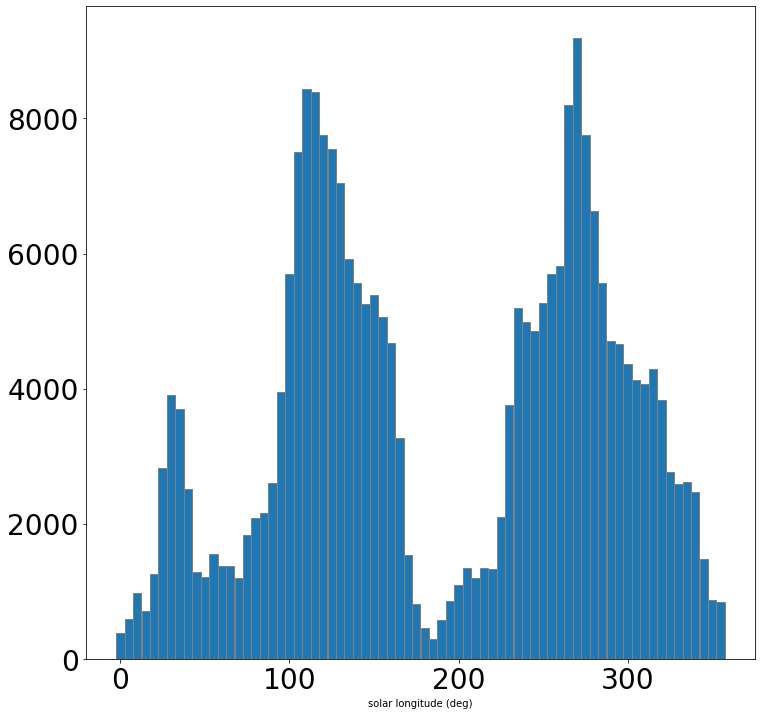

In [36]:
hist_LtSun, hl = numpy.histogram(pointings[:,6]/deg,bins=72,range=(0,360))

plt.xlabel('solar longitude (deg)')
plt.bar(hl[:-1], hist_LtSun, edgecolor ='grey', width=4.99) 
plt.show()

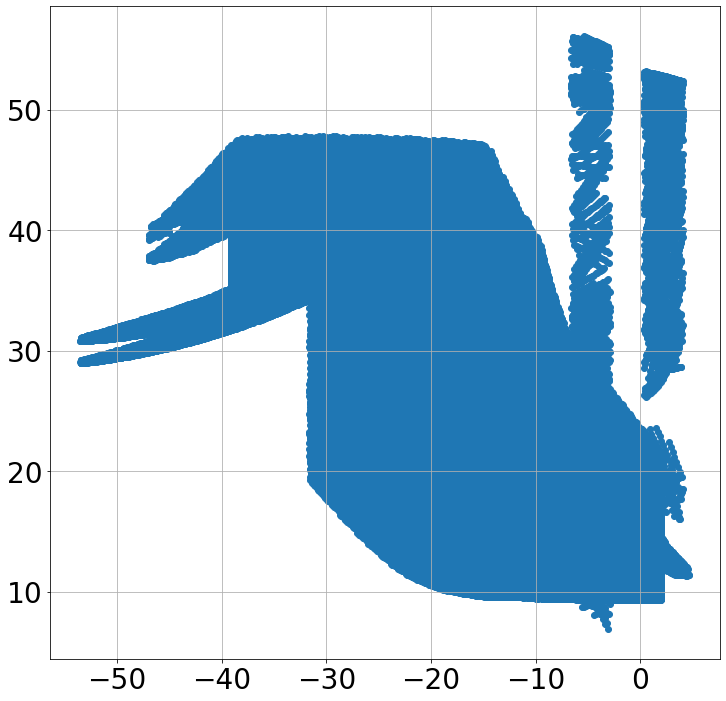

In [37]:
plt.scatter(pointings[:,col['dec']]/deg, (pointings[:,col['tend']]-pointings[:,col['tstart']])*365.25)
plt.grid()
plt.show()

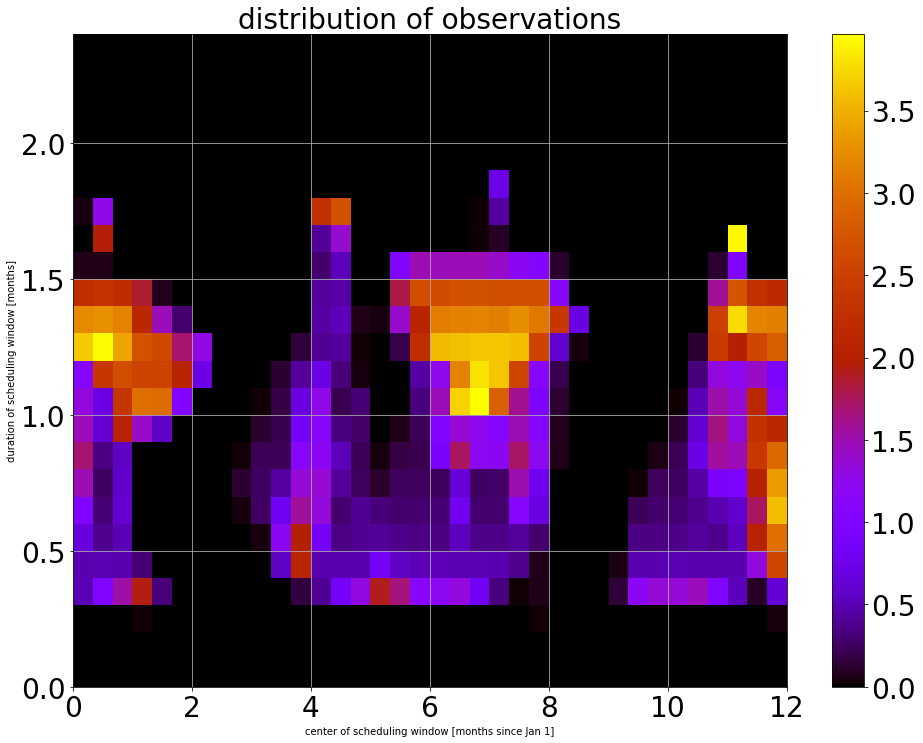

In [38]:
plt.rcParams['figure.figsize'] = [16,12]
dur = (pointings[:,col['tend']]-pointings[:,col['tstart']])*12
ctr = rephase((pointings[:,col['tend']]+pointings[:,col['tstart']])/2.*2*numpy.pi)/2/numpy.pi*12
H, yedges, xedges = numpy.histogram2d(dur, ctr, bins=[numpy.arange(25)/10., numpy.arange(37)/3.], weights=pointings[:,col['t_exp']]/86400.)
fig, (ax1) = plt.subplots(ncols=1, sharey=True)
i=ax1.pcolormesh(xedges, yedges, H, cmap='gnuplot')
ax1.set_xlabel('center of scheduling window [months since Jan 1]')
ax1.set_ylabel('duration of scheduling window [months]')
ax1.set_title('distribution of observations')
ax1.grid()
fig.colorbar(i)
plt.show()

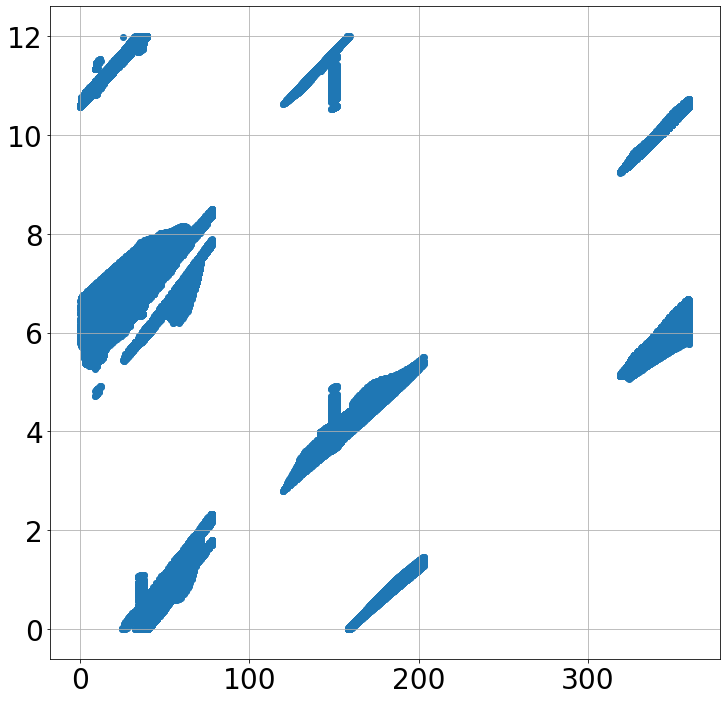

In [39]:
plt.rcParams['figure.figsize'] = [12,12]
plt.scatter(pointings[:,col['ra']]/deg, rephase((pointings[:,col['tstart']]+pointings[:,col['tend']])*numpy.pi)*6/numpy.pi)
plt.grid()
plt.show()

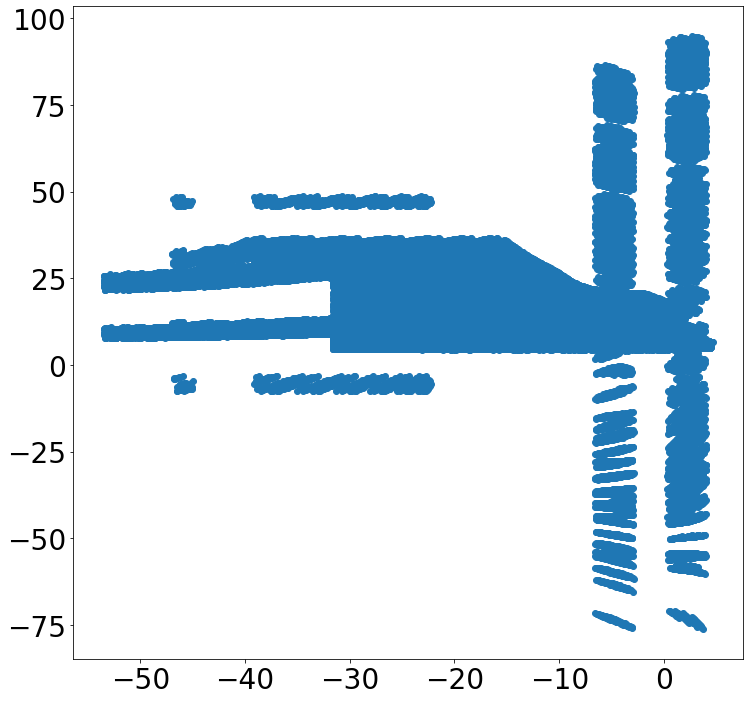

In [40]:
plt.scatter(pointings[:,col['dec']]/deg, rephase(pointings[:,col['LtSun_opt']]-LtStart-numpy.pi)/deg-180)
plt.show()

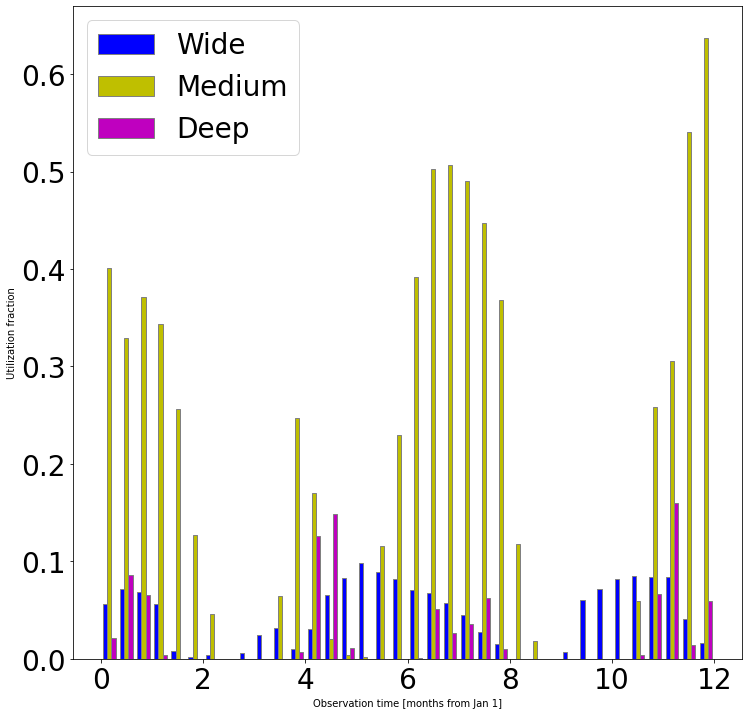

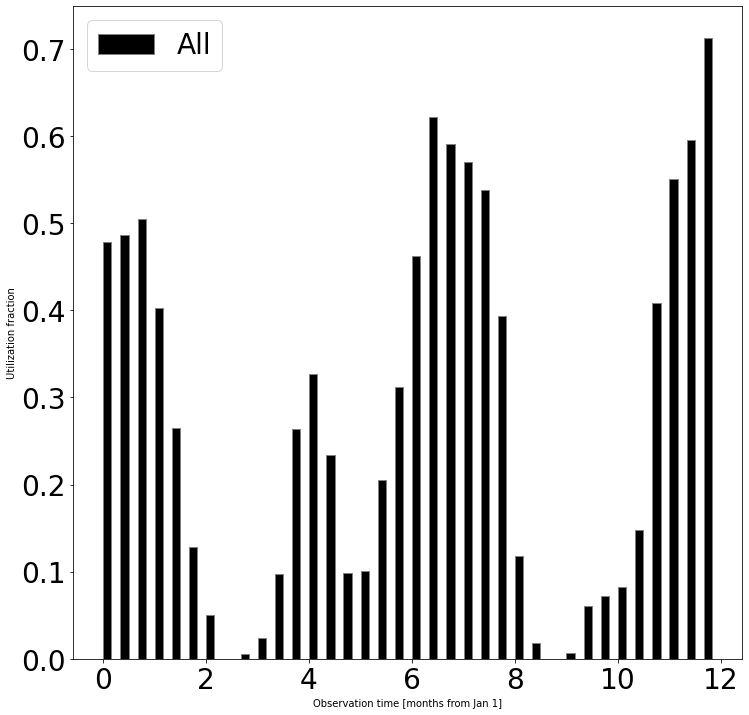

total = 1.3797878521637863 years


In [41]:
nbe=36
be_date = numpy.linspace(0,1-1/nbe,nbe)*12

Nobs = numpy.shape(pointings)[0]
t_use = numpy.zeros((nbe,3))
for i in range(Nobs):
    z = min(int(pointings[i,col['layer']]),2)
    this_t = (pointings[i,col['tstart']]+pointings[i,col['tend']])/2.
    if this_t>=1: this_t -= 1
    x = int(numpy.floor(this_t*nbe))
    t_use[x,z] += pointings[i,col['t_exp']]
    if i>1: t_use[x,z] += dt[i-1]
t_use *= nbe/(86400*365.25)

barWidth = 0.08
# breakdown by Wide-Med-Deep
o = (be_date[1]-be_date[0])/2.-barWidth
plt.xlabel('Observation time [months from Jan 1]')
plt.ylabel('Utilization fraction')
cc = ['b', 'y', 'm']
lblb = ['Wide', 'Medium', 'Deep']
for i in range(3):
    plt.bar(be_date+o+i*barWidth, t_use[:,i]/5., color =cc[i], width = barWidth, 
        edgecolor ='grey', label =lblb[i]) 
plt.legend()
plt.show()
# total
plt.xlabel('Observation time [months from Jan 1]')
plt.ylabel('Utilization fraction')
plt.bar(be_date+o, numpy.sum(t_use,axis=1)/5., color ='k', width = barWidth*2, 
        edgecolor ='grey', label ='All') 
plt.legend()
plt.show()

print('total =', numpy.sum(t_use)/nbe, 'years')

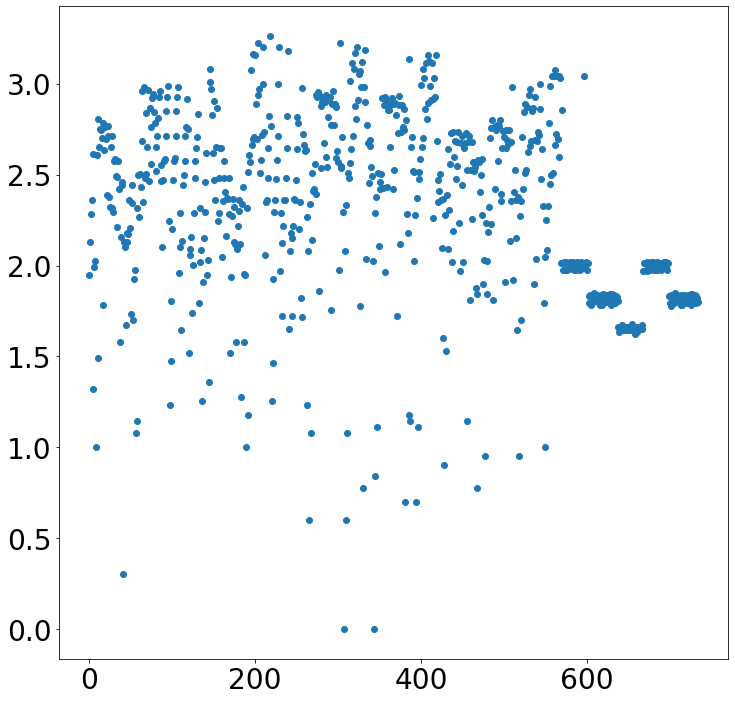

(array([  8,  41, 189, 265, 307, 309, 330, 343, 345, 381, 394, 428, 468,
       477, 518, 550]),)


In [42]:
# subgroup sizes
n__ = numpy.amax(subgrp2)+1
ct = numpy.zeros(n__,dtype=numpy.int32)
for j in range(n__): ct[j] = numpy.count_nonzero(subgrp2==j)
plt.scatter(numpy.arange(n__), numpy.log10(ct))
plt.show()
print(numpy.where(ct<=10))

In [43]:
# for displaying text:
# letters of the alphabet
letters = numpy.loadtxt('letters.dat').reshape((256,12,6)).astype(numpy.uint16)
def write_text(image, origin, size, val, string):
  (posy, posx) = origin
  for i in range(len(string)):
    #print(string[i], posx, posy, numpy.shape(image))
    if posx+size*6>numpy.shape(image)[-1] or posy+size*12>numpy.shape(image)[-2]: break
    card = letters[ord(string[i]),::-1,:]
    card = numpy.repeat(numpy.repeat(card, size, axis=0), size, axis=1)
    #print(numpy.shape(card), numpy.shape(image), 'size', size, 'at', (posx,posy))
    image[posy:posy+size*12,posx:posx+size*6] = numpy.where(card>0, val, image[posy:posy+size*12,posx:posx+size*6])
    posx += size*8

def write_text2(image3D, RA_, Dec_, size, val, string):
    origin = (int(le/2.*(1+numpy.sin(Dec_))), int(le*(2-RA_/numpy.pi)))
    for i in range(3):
        write_text(image3D[:,:,i], origin, size, val[i], string)



In [44]:
# print to FITS image
w = wcs.WCS(naxis=2)
w.wcs.crpix = [le+.5, (le+1)/2.]
w.wcs.cdelt = [-180./le, 180./le*2./numpy.pi]
w.wcs.crval = [180., 0.]
w.wcs.ctype = ["RA---CEA", "DEC--CEA"]
outimage2 = footprint[0,:,:]+2*footprint[1,:,:]
outimage2 = outimage2 + numpy.minimum(EBV,.2)*3
outimage2 = numpy.where(numpy.abs(beta)<.08333*deg,2.6,outimage2)
isDeep = numpy.zeros((le,2*le),dtype=bool)
for jd in deepfields:
    mu = numpy.cos(Dec)*numpy.cos(jd['DECc'])*numpy.cos(RA-jd['RAc'])+numpy.sin(Dec)*numpy.sin(jd['DECc'])
    isDeep |= mu>numpy.cos(jd['r'])
outimag2 = numpy.where(isDeep, 1.6, outimage2)
DECc = numpy.asarray([-44.0, -28.1])*deg
RAc = numpy.asarray([9.45, 53.125])*deg
# display the other LSST fields
isDeep2 = numpy.zeros((le,2*le),dtype=bool)
for i in range(2):
    mu = numpy.cos(Dec)*numpy.cos(DECc[i])*numpy.cos(RA-RAc[i])+numpy.sin(Dec)*numpy.sin(DECc[i])
    isDeep2 |= numpy.logical_and(mu>numpy.cos(1.825*deg),mu<numpy.cos(1.675*deg))
outimage2 = numpy.where(isDeep2, 0., outimage2)

# and the Euclid EDF-S

RAe = numpy.asarray([63.25,65.35,66.40,65.99,59.25,56.95,55.90,56.80])*deg
DECe = numpy.asarray([-45.67,-46.10,-47.25,-48.72,-51.19,-50.82,-49.40,-47.99])*deg
nj=100
for i in range(8):
    print(i)
    for j in range(nj):
        r = RAe[i-1] + (RAe[i]-RAe[i-1])*j/nj
        d = DECe[i-1] + (DECe[i]-DECe[i-1])*j/nj
        mu = numpy.cos(Dec)*numpy.cos(d)*numpy.cos(RA-r)+numpy.sin(Dec)*numpy.sin(d)
        outimage2 = numpy.where(mu>numpy.cos(0.1*deg), 0., outimage2)

fits.PrimaryHDU(outimage2[::-1,:], header=w.to_header()).writeto('footprint2.fits', overwrite=True)

# now draw an image
from PIL import Image
from matplotlib import cm
im = (getattr(cm,'CMRmap')(outimage2/2.6)*255).astype(numpy.uint8)[::-1,:,:3]

# change deep fields
im[:,:,0] = numpy.where(isDeep[::-1,:],96,im[:,:,0])
im[:,:,1] = numpy.where(isDeep[::-1,:],96,im[:,:,1])
im[:,:,2] = numpy.where(isDeep[::-1,:],96,im[:,:,2])

# grid
grid = numpy.zeros((le,le*2),dtype=numpy.uint8)
for a in range(1,24):
    grid[:,(a*le*2)//24] = 1
for a in range(-8,9):
    v = int(le/2*(1.+numpy.sin(a*10*deg)))
    grid[v,:] = 1
im[:,:,0] = numpy.where(grid>0,0,im[:,:,0])
im[:,:,1] = numpy.where(grid>0,128,im[:,:,1])
im[:,:,2] = numpy.where(grid>0,0,im[:,:,2])
im[le//2-1:le//2+2,:,:] = 255

for a in range(1,24):
    write_text2(im, 15*deg*a+3*deg, 5.*deg, 3, [0,255,255], '{:2d}h'.format(a))
for a in [-5,-4,-3,-2,-1,1,2,3,4,5]:
    write_text2(im, 265*deg, 10.*a*deg-.5*deg, 3, [0,255,255], '{:3d}°'.format(10*a))
write_text2(im,154*deg,-2*deg, 3, [0,0,64], 'COSMOS')
write_text2(im,44.5*deg,-8.3*deg, 3, [0,0,64], 'XMM-LSS')
write_text2(im,14.75*deg,-41.5*deg, 3, [0,0,64], 'ELAIS')
write_text2(im,50.5*deg,-29*deg, 3, [0,0,64], 'CDFS')
write_text2(im,65*deg,-45*deg, 3, [0,0,64], 'EDF-S')

write_text2(im,95*deg,24*deg, 3, [255,255,255], 'Ecliptic')
write_text2(im,269*deg,-2*deg, 3, [255,255,255], 'Equator')

write_text2(im,202.5*deg,-17.5*deg, 4, numpy.asarray(getattr(cm,'CMRmap')([1.05/2.6])*255).astype(numpy.uint8).flatten()[:3], 'Wide')
write_text2(im,150*deg,-18.5*deg, 4, numpy.asarray(getattr(cm,'CMRmap')([2.05/2.6])*255).astype(numpy.uint8).flatten()[:3], 'Medium')


Image.fromarray(im[::-1,:,:]).save('skychart.png')

0
1
2
3
4
5
6
7


# 